# Objetivo y dataset

El objetivo principal consiste
en desarrollar un modelo predictivo, a partir de información de valor y mediante el uso de modelos lineales generalizados, que permita predecir el precio de un determinado coche en Australia.


# Selección de datos

Con la finalidad de la resolución del objetivo planteado, se precisan diferentes datos actualizados referentes a los vehículos de Australia. Esta información debe recoger tanto los atributos que afectan directamente a dichos vehículos, así como también involucrar a otros factores externos.

In [1]:
# Se importan las librerías necesarias y se adaptan las configuraciones pertinentes.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

A continuación, se importan los tres conjuntos de datos involucrados.

In [2]:
# Dataset principal considerado con información de precios de coches en Australia en 2023.
car = pd.read_csv('Australian Vehicle Prices.csv')

In [3]:
# Índice de precios.
pr = pd.read_excel('Price_Index_Australia.xlsx')

In [4]:
# Cambio de moneda entre el dólar australiano y el euro.
coin = pd.read_csv('euro-daily-hist_1999_2022.csv')

# Unificación de datos

El siguiente paso consiste en unificar toda la información de los distintos conjuntos de datos.



*   A partir del fichero en formato Excel, que contiene el valor del índice de precios, y del fichero en formato CSV, que contiene el ratio del dólar australiano respecto al euro, se han calculado y obtenido los valores medios anuales tanto del índice de precios como del ratio de la moneda australiana.
*   Se adjuntan en el fichero principal de los precios de coches en Australia dos columnas nuevas, correspondientes a las variables anteriormente calculadas. La unión se realiza mediante el atributo Year, es decir, para cada año de fabricación de cada vehículo, se añade el valor medio anual del índice de precio y el ratio del dólar australiano respecto al euro. Cabe mencionar que la columna Year contenía un valor perdido que ha sido imputado por el método ffill antes de abordar este procedimiento.




In [5]:
# Se añade la columna Year en los datasets coin y pr, comprobando que no tienen valores faltantes.
coin[coin.columns[0]] = pd.to_datetime(coin[coin.columns[0]])
pr[pr.columns[0]] = pd.to_datetime(pr[pr.columns[0]])
coin['Year'] = coin[coin.columns[0]].dt.year
pr['Year'] = pr[pr.columns[0]].dt.year
print('¿Tiene valores faltantes el año del dataset del cambio de moneda?', pd.isnull(coin['Year']).any(), '\n¿Tiene valores faltantes el año del dataset del índice de precios?', pd.isnull(pr['Year']).any())

¿Tiene valores faltantes el año del dataset del cambio de moneda? False 
¿Tiene valores faltantes el año del dataset del índice de precios? False


In [6]:
# Se identifican los valores faltantes del cambio de moneda de dólar australiano a euro (definidos por un guion) y se imputan por el método fill.
ad = coin.columns[1]
ip = pr.columns[1]
aux = []
for i in coin[ad]:
  if str(i) == '-':
    aux.append(None)
  else :
    aux.append(float(i))

coin[ad] = aux
coin[ad].fillna(method='ffill', inplace=True)

# Se comprueba que el índice de precios no tiene valores faltantes y se convierte a numérico
print('Valores faltantes del índice de precios: ', pr[ip].isnull().sum(), '\n')
pr[ip]= pr[ip].astype('float64')
print('¿Hay valores faltantes en el cambio de moneda entre el dólar australiano y el euro después de su imputación? ', pd.isnull(coin[ad]).any())

Valores faltantes del índice de precios:  0 

¿Hay valores faltantes en el cambio de moneda entre el dólar australiano y el euro después de su imputación?  False


In [7]:
# Se obtiene el valor medio anual del cambio de dólar australiano a euro y del índice de precios.
coinGroup = coin.groupby(['Year']).mean()[ad]
priceGroup = pr.groupby(['Year']).mean()[ip]

<ipython-input-7-c1087b1e5c60>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  coinGroup = coin.groupby(['Year']).mean()[ad]
<ipython-input-7-c1087b1e5c60>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  priceGroup = pr.groupby(['Year']).mean()[ip]


In [8]:
# Se imputa el único Missing Value en el año de fabricación del dataset principal (método fill) y se convierte a entera la columna.
print('Valores faltantes de Year en el datset principal antes de su imputación: ', car['Year'].isnull().sum())
car['Year'].fillna(method='ffill', inplace=True)
print('Valores faltantes de Year en el datset principal después de su imputación: ', car['Year'].isnull().sum())
car['Year'] = car['Year'].astype('Int64')

Valores faltantes de Year en el datset principal antes de su imputación:  1
Valores faltantes de Year en el datset principal después de su imputación:  0


In [9]:
# Se añade en el dataset principal el valor medio anual del cambio de moneda entre dólar australiano y euro y el índice de precios medio anual.
aux1 = []
aux2 = []
for i in car['Year']:
  if i in coinGroup.index:
    aux1.append(float(coinGroup[i]))
  else:
    aux1.append(None)
  if i in priceGroup.index:
    aux2.append(float(priceGroup[i]))
  else:
    aux2.append(None)

car['DollarAustralian'] = aux1
car['PriceIndex'] = aux2

De esta forma, ya se dispone de toda la información centralizada en el dataset car, cuyo resumen es el siguiente

In [10]:
print('El dataset contiene', car.shape[0], 'filas y', car.shape[1], 'columnas.')
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

El dataset contiene 16734 filas y 21 columnas.
Las columnas, con sus correspondientes tipos, son las siguientes:
 Brand                 object
Year                   Int64
Model                 object
Car/Suv               object
Title                 object
UsedOrNew             object
Transmission          object
Engine                object
DriveType             object
FuelType              object
FuelConsumption       object
Kilometres            object
ColourExtInt          object
Location              object
CylindersinEngine     object
BodyType              object
Doors                 object
Seats                 object
Price                 object
DollarAustralian     float64
PriceIndex           float64
dtype: object


# Preparación y transformación de los datos

**Variables numéricas:** el formato de la mayoría de los atributos numéricos contiene texto, por lo que es necesario realizar la correspondiente transformación en cada uno de ellos para convertirlos en variables numéricas enteras o reales, según su naturaleza.

In [11]:
# Adecuación de tipos y comprobación si son enteros.

#Variable Engine
l = []
for i in car['Engine']:
  aux1 = str(i).find(',') # Devuelve -1 si no lo encuentra.
  aux2 = str(i).find('L') # Devuelve -1 si no lo encuentra.
  if aux1 != -1 and aux2 != -1:
    l.append(float(i[aux1+2:aux2-1]))
  elif i == '0 L' or i == '2 L':
    l.append(float(i[0]))
  elif i == '-' or pd.isna(i) or i == '4 cyl':
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Engine con formato no identificado.")

car['Engine'] = l


# Variable CylindersinEngine -> Cylinders
l = []
for i in car['CylindersinEngine']:
  aux = str(i).find('c')
  if aux != -1:
    l.append(int(i[0:aux]))
  elif i == '0 L' or i == '2 L' or i == '-' or pd.isna(i):
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en CylindersinEngine con formato no identificado.")

car['CylindersinEngine'] = l
car.rename(columns = {list(car)[14]:'Cylinders'}, inplace=True)
car['Cylinders'] = car['Cylinders'].astype('Int64')

# Variable FuelConsumption
l = []
for i in car['FuelConsumption']:
  aux = str(i).find('L')
  if aux != -1:
    l.append(float(i[0:aux]))
  elif i =='-' or pd.isna(i) :
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en FuelConsumption con formato no identificado.")

car['FuelConsumption'] = l

# Variable Doors

l = []
for i in car['Doors']:
  aux1 = str(i).find('D')
  aux2 = str(i).find('S')
  if aux1 != -1:
    l.append(int(i[0:aux1]))
  elif  i =='-' or pd.isna(i) or aux2 != -1:
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Doors con formato no identificado.")

car['Doors']=l
car['Doors'] = car['Doors'].astype('Int64')

# Variable Seats

l = []
for i in car['Seats']:
  aux = str(i).find('S')
  if aux != -1:
    l.append(int(i[0:aux]))
  elif  i =='-' or pd.isna(i) :
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Seats con formato no identificado.")

car['Seats'] = l
car['Seats'] = car['Seats'].astype('Int64')

# Variable kilometres
l = []
for i in car['Kilometres']:
  if str(i).isnumeric():
    l.append(float(i))
  elif  i =='-' or pd.isna(i) or i == '- / -':
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Kilometres con formato no identificado.")

car['Kilometres'] = l

# Variable Price
l = []
for i in car['Price']:
  if str(i).isnumeric():
    l.append(float(i))
  elif  i =='-' or pd.isna(i) or i == 'POA':
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Price con formato no identificado.")

car['Price'] = l

In [12]:
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

Las columnas, con sus correspondientes tipos, son las siguientes:
 Brand                object
Year                  Int64
Model                object
Car/Suv              object
Title                object
UsedOrNew            object
Transmission         object
Engine              float64
DriveType            object
FuelType             object
FuelConsumption     float64
Kilometres          float64
ColourExtInt         object
Location             object
Cylinders             Int64
BodyType             object
Doors                 Int64
Seats                 Int64
Price               float64
DollarAustralian    float64
PriceIndex          float64
dtype: object


**Eliminación de variables:** a continuación, se identifican aquellas variables no numéricas con un número demasiado alto de categorías distintas, decidiéndose prescindir de ellas a causa de su elevada complejidad en la futura fase de aplicación de un modelo lineal generalizado, y a su reducida aportación de variabilidad en la variable respuesta.

In [13]:
# Columnas a eliminar por tener un número excesivo de categorías.
cols_to_drop = ['Brand', 'Model', 'Car/Suv', 'Title', 'ColourExtInt', 'Location']
for i in cols_to_drop:
  print('Resumen de', i, ":")
  print(car[i].value_counts())
  print("\n")

Resumen de Brand :
Toyota         2784
Hyundai        1239
Mazda          1179
Holden         1087
Ford           1055
               ... 
Proton            1
Daewoo            1
Hummer            1
Rolls-Royce       1
Packard           1
Name: Brand, Length: 76, dtype: int64


Resumen de Model :
Hilux          430
Corolla        405
Ranger         398
Landcruiser    370
I30            366
              ... 
Celerio          1
R-Class          1
Vectra           1
ES300            1
120              1
Name: Model, Length: 781, dtype: int64


Resumen de Car/Suv :
SUV                             5921
Hatchback                       2365
Ute / Tray                      2068
Sedan                           1898
Wagon                            577
                                ... 
Werribee Hyundai                   1
Bay City Holden Used.              1
Auto Mega Warehouse Brisbane       1
Consign-A-Car P/L (Kedron)         1
Australian Vehicle Locators        1
Name: Car/Suv, Length: 6

In [14]:
# Eliminación de las variables.
cols_to_drop = ['Brand', 'Model', 'Car/Suv', 'Title', 'ColourExtInt', 'Location']
car = car.drop(cols_to_drop, axis=1)

**Variables categóricas:** seguidamente, de aquellas otras variables no numéricas, se decide realizar la correspondiente transformación en cada una con el objetivo de limitar y optimizar el número de categorías distintas.

In [15]:
cols_to_reduce = ['UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 'BodyType']
for i in cols_to_reduce:
  print('Resumen de', i, ":")
  print(car[i].value_counts())
  print("\n")

Resumen de UsedOrNew :
USED    14994
NEW      1227
DEMO      512
Name: UsedOrNew, dtype: int64


Resumen de Transmission :
Automatic    14530
Manual        1952
-              251
Name: Transmission, dtype: int64


Resumen de DriveType :
Front    6978
4WD      3143
AWD      3113
Rear     2350
Other    1149
Name: DriveType, dtype: int64


Resumen de FuelType :
Unleaded    6985
Diesel      4905
Premium     3377
Hybrid       652
-            637
Electric     115
Other         42
LPG           15
Leaded         5
Name: FuelType, dtype: int64


Resumen de BodyType :
SUV             6907
Hatchback       2697
Ute / Tray      2512
Sedan           1983
Wagon           1232
Commercial       610
Coupe            336
Convertible      131
Other             23
People Mover      21
Name: BodyType, dtype: int64




Acerca de FuelType y BodyType, al contener respectivamente 9 y 10 categorías distintas, se opta por reducir estos valores significativamente, agrupando en Other aquellas categorías menos relevantes, tal y como se observa
 en los siguientes gráficos. De esta forma, el número de parámetros del futuro modelo lineal generalizado se verá drásticamente reducido, siendo más parsimonioso y menos complejo.

Text(0.5, 1.0, 'Tipos de combustible después')

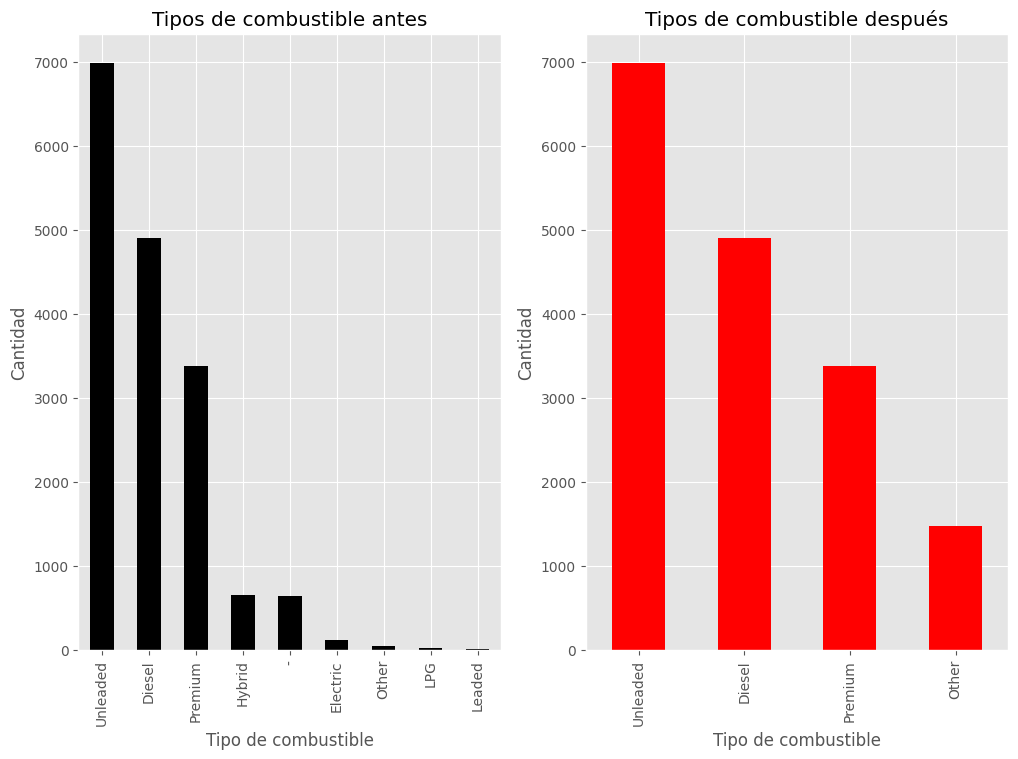

In [16]:
l = []
for i in car['FuelType']:
  if i != 'Unleaded' and i != 'Diesel' and i != 'Premium':
    l.append('Other')
  else :
    l.append(i)

s = pd.Series(l)
plt.subplot(1, 2, 1)
car['FuelType'].value_counts().plot.bar(color = 'black')
plt.xlabel('Tipo de combustible')
plt.ylabel('Cantidad')
plt.title('Tipos de combustible antes')

plt.subplot(1, 2, 2)
s.value_counts().plot.bar(color = 'red')
plt.xlabel('Tipo de combustible')
plt.ylabel('Cantidad')
plt.title('Tipos de combustible después')



Text(0.5, 1.0, 'Estilos de coche después')

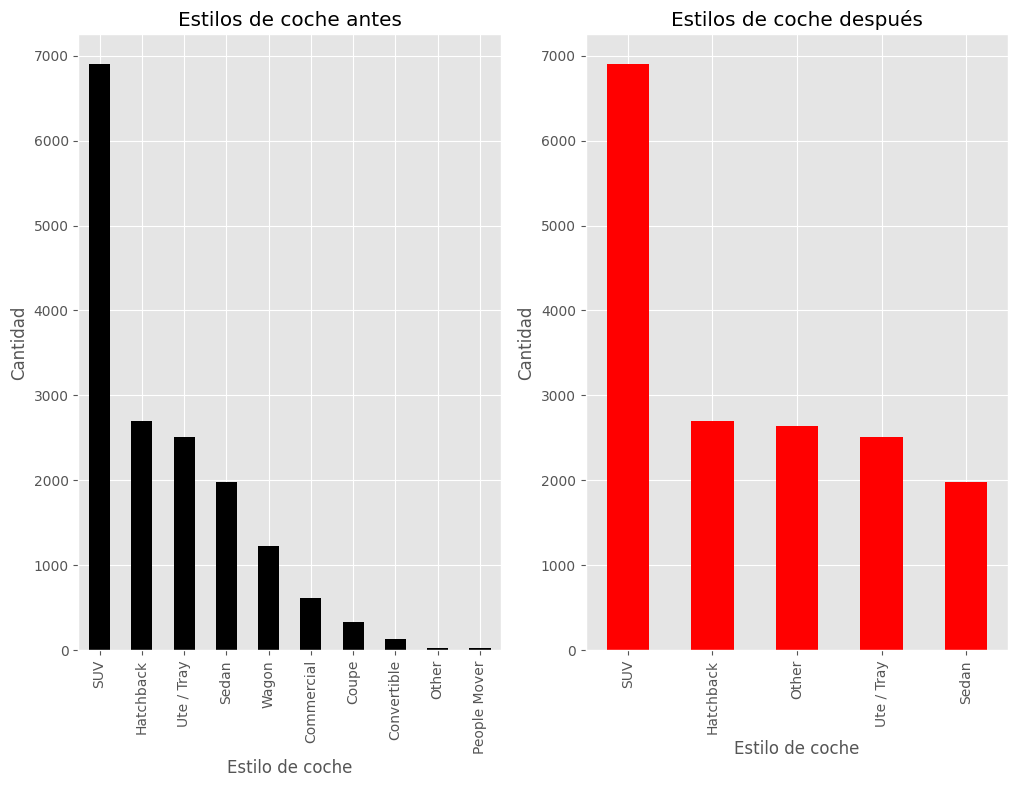

In [17]:
l = []
for i in car['BodyType']:
  if i != 'SUV' and i != 'Hatchback' and i != 'Ute / Tray' and i != 'Sedan':
    l.append('Other')
  else :
    l.append(i)

s = pd.Series(l)
plt.subplot(1, 2, 1)
car['BodyType'].value_counts().plot.bar(color = 'black')
plt.xlabel('Estilo de coche')
plt.ylabel('Cantidad')
plt.title('Estilos de coche antes')

plt.subplot(1, 2, 2)
s.value_counts().plot.bar(color = 'red')
plt.xlabel('Estilo de coche')
plt.ylabel('Cantidad')
plt.title('Estilos de coche después')

In [18]:
# Transformación de los gráficos anteriores.
l = []
for i in car['FuelType']:
  if i != 'Unleaded' and i != 'Diesel' and i != 'Premium':
    l.append('Other')
  else :
    l.append(i)

car['FuelType'] = l

l = []
for i in car['BodyType']:
  if i != 'SUV' and i != 'Hatchback' and i != 'Ute / Tray' and i != 'Sedan':
    l.append('Other')
  else :
    l.append(i)

car['BodyType'] = l



# Tratamiento de valores perdidos

In [19]:
# Listado por porcentajes de valores perdidos por característica.
for col in car.columns:
    pct_missing = np.mean(car[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

Year - 0.0%
UsedOrNew - 0.01%
Transmission - 0.01%
Engine - 10.02%
DriveType - 0.01%
FuelType - 0.0%
FuelConsumption - 10.15%
Kilometres - 3.54%
Cylinders - 10.65%
BodyType - 0.0%
Doors - 10.01%
Seats - 10.19%
Price - 0.32%
DollarAustralian - 0.54%
PriceIndex - 17.4%


Text(0.5, 1.0, 'Mapa de calor de valores faltantes por variable')

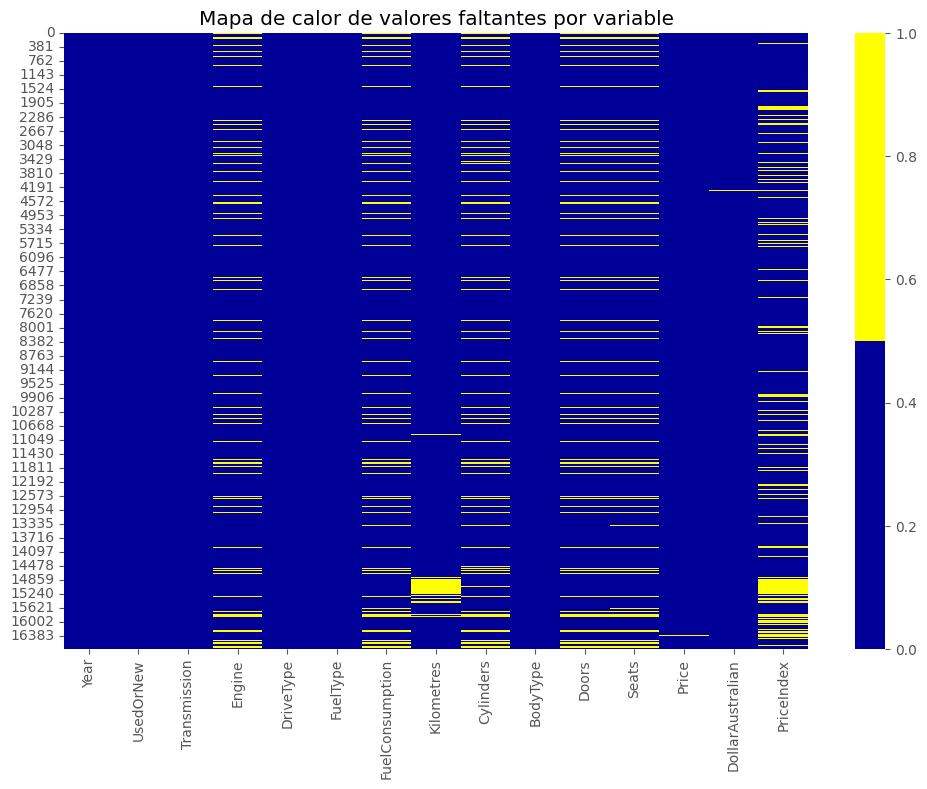

In [20]:
# Mapa de calor de valores perdidos por columna.
cols = car.columns
colours = ['#000099', '#ffff00'] # especificamos los colores - amarillo es missing. Azul no es missing.
sns.heatmap(car[cols].isnull(), cmap=sns.color_palette(colours))
plt.title('Mapa de calor de valores faltantes por variable')

Aunque ninguna de las columnas presenta un número excesivo de valores faltantes, sí que es cierto que la mayoría de ellas tiene un porcentaje a tener en cuenta, tal y como se plasma en el mapa de calor anterior. Particularmente, todas las variables, a excepción del año de fabricación, del tipo de combustible y del estilo del coche, presentan al menos un valor faltante (aunque en algunos casos es tan insignificante que ni se contempla en el mapa).


Al ser la variable de los cilindros con un 10.65%, la columna que más valores faltantes muestra, se opta por llevar a cabo una imputación o reemplazo de todos los valores faltantes del conjunto de datos, sin eliminar ninguna fila, de forma que se prescinda de la menor información posible. El detalle se encuentra en la siguiente celda.

   


In [21]:
# Variables categóricas
# UsedOrNew: se añaden los valores faltantes a USED (la moda).
# Transmission: se añaden los valores faltantes a Automatic (la moda).
# DriveType: se añaden los valores faltantes a Other.

col_top = ['UsedOrNew', 'Transmission']

# Reemplazo de valores faltantes de UsedOrNew y Transmission.
for col in col_top:
    missing = car[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:
        top = car[col].describe()['top']
        car[col] = car[col].fillna(top)

# Reemplazo de valores "-" en Transmission por Automatic.
l = []
for i in car['Transmission']:
  if i == '-':
    l.append('Automatic')
  else :
    l.append(i)

car['Transmission'] = l

# Reemplazo de valores faltantes de DriveType.
l = []
for i in car['DriveType']:
  if pd.isna(i):
    l.append('Other')
  else :
    l.append(i)

car['DriveType'] = l

In [22]:
# Variables numéricas
# Todos sus valores faltantes se reemplazan por la mediana de cada columna correspondiente.
num_mi_col = ['Engine', 'FuelConsumption', 'Kilometres', 'Cylinders', 'Doors', 'Seats', 'DollarAustralian', 'PriceIndex', 'Price']
for col in num_mi_col:
    missing = car[col].isnull()
    num_missing = np.sum(missing)
    print('Imputando valores faltantes de: {}'.format(col))
    med = car[col].median()
    if col in ('Cylinders', 'Doors', 'Seats'):
      med = int(med)
    car[col] = car[col].fillna(med)

# Comprobamos que los  campos ya no presentan valores faltantos.
print('\n')
for col in num_mi_col:
  print('Valores faltantes en', col, ':', car[col].isnull().sum())

Imputando valores faltantes de: Engine
Imputando valores faltantes de: FuelConsumption
Imputando valores faltantes de: Kilometres
Imputando valores faltantes de: Cylinders
Imputando valores faltantes de: Doors
Imputando valores faltantes de: Seats
Imputando valores faltantes de: DollarAustralian
Imputando valores faltantes de: PriceIndex
Imputando valores faltantes de: Price


Valores faltantes en Engine : 0
Valores faltantes en FuelConsumption : 0
Valores faltantes en Kilometres : 0
Valores faltantes en Cylinders : 0
Valores faltantes en Doors : 0
Valores faltantes en Seats : 0
Valores faltantes en DollarAustralian : 0
Valores faltantes en PriceIndex : 0
Valores faltantes en Price : 0


In [23]:
# Resumen del conjunto de datos.
print('El dataset contiene', car.shape[0], 'filas y', car.shape[1], 'columnas.')
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

El dataset contiene 16734 filas y 15 columnas.
Las columnas, con sus correspondientes tipos, son las siguientes:
 Year                  Int64
UsedOrNew            object
Transmission         object
Engine              float64
DriveType            object
FuelType             object
FuelConsumption     float64
Kilometres          float64
Cylinders             Int64
BodyType             object
Doors                 Int64
Seats                 Int64
Price               float64
DollarAustralian    float64
PriceIndex          float64
dtype: object


# Selección de características

 Considerando que la variable respuesta es el precio, se ve conveniente hacer
 especial hincapié su relación con el resto de variables, tanto numéricas como categóricas.

 Acerca de las variables numéricas explicativas o de entrada, lo que interesa es que no se encuentren muy relacionadas entre ellas, ya que en caso de añadirse estas en el futuro modelo se incorporaría bastante redundancia, ocasionando distintos problemas que dificultarían su interpretación. Sin embargo, en referencia a la relación de cada una de ellas individualmente con la variable de salida del precio, sí es de especial interés que se encuentren lo más relacionadas posibles, ya que aportarán mayor capacidad predictiva y mejor ajuste al modelo.


Con la matriz de correlaciones entre todas las variables numéricas mostrada en
 la siguiente celda, se puede apreciar que la mayor correlación entre las variables de entrada se obtiene entre la cilindrada del motor y su potencia, siendo de 0,8, lo que parece obvio, pues a mayor número de cilindros tenga el motor, más potencia tendrá. Sin embargo, debido a que esta correlación tampoco es excesivamente alta y a que dichas columnas son de las que más relacionadas están con el precio, siendo superada alguna de ellas solo por el año de fabricación, los kilómetros recorridos o el índice de precios, se decide no prescindir de ninguna de ellas. Acerca de las demás variables explicativas, al no estar muy relacionadas entre ellas, tampoco se ve necesaria su eliminación, a pesar de que alguna de ellas, como la tasa de consumo de combustible, esté muy poco correlacionada con el precio, ya que puede darse el caso de que sí influya en dicha variable de salida de forma no lineal.

In [24]:
# Matriz de correlaciones
corr_matrix = car.corr()
corr_matrix

<ipython-input-24-03c6e34013dc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = car.corr()


,Year,Engine,FuelConsumption,Kilometres,Cylinders,Doors,Seats,Price,DollarAustralian,PriceIndex
Year,1.000000,-0.182471,-0.258235,-0.696667,-0.172040,0.066991,0.014712,0.351451,0.123917,0.746127
Engine,-0.182471,1.000000,0.557007,0.232809,0.804203,-0.315065,0.038717,0.255675,0.012041,-0.150460
FuelConsumption,-0.258235,0.557007,1.000000,0.218492,0.509391,-0.169453,0.076615,0.021749,-0.026594,-0.243990
Kilometres,-0.696667,0.232809,0.218492,1.000000,0.140161,-0.112854,0.001587,-0.347778,-0.179824,-0.578763
Cylinders,-0.172040,0.804203,0.509391,0.140161,1.000000,-0.238393,0.016651,0.334112,0.000717,-0.147121
Doors,0.066991,-0.315065,-0.169453,-0.112854,-0.238393,1.000000,0.369554,-0.177394,-0.011402,0.058987
Seats,0.014712,0.038717,0.076615,0.001587,0.016651,0.369554,1.000000,-0.041135,0.008452,0.024777
Price,0.351451,0.255675,0.021749,-0.347778,0.334112,-0.177394,-0.041135,1.000000,0.149495,0.278544
DollarAustralian,0.123917,0.012041,-0.026594,-0.179824,0.000717,-0.011402,0.008452,0.149495,1.000000,0.110870
PriceIndex,0.746127,-0.150460,-0.243990,-0.578763,-0.147121,0.058987,0.024777,0.278544,0.110870,1.000000


In [25]:
# Matriz de correlaciones acotado a los atributos muy relacionados.
corr_matrix[(corr_matrix > 0.85) | (corr_matrix < -0.85)]

,Year,Engine,FuelConsumption,Kilometres,Cylinders,Doors,Seats,Price,DollarAustralian,PriceIndex
Year,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FuelConsumption,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometres,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Cylinders,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Doors,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Seats,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
DollarAustralian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
PriceIndex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


 Por otro lado, para cada una de las variables no numéricas, se calcula el valor medio del precio en cada categoría, unificando aquellas excesivamente similares con la finalidad de eliminar posible redundancia y reducir el número de parámetros en el futuro modelo. El detalle se encuentra en las siguientes celdas.

Text(0, 0.5, 'Precio')

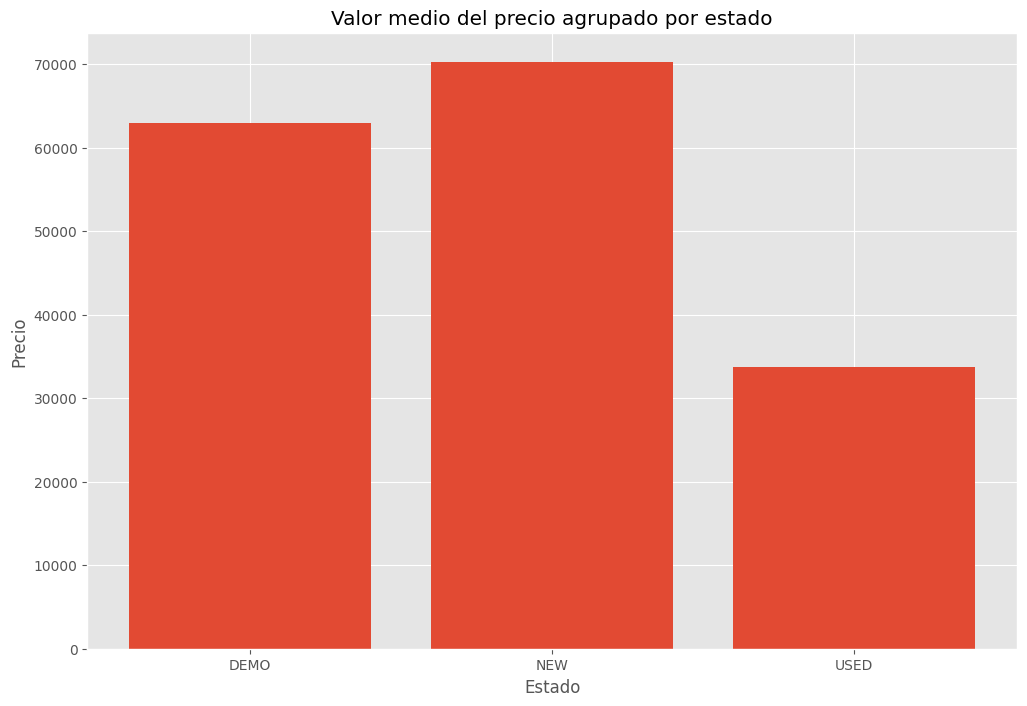

In [26]:
# UsedOrNew: sin cambios
UsedOrNew_grouped = car[['UsedOrNew', 'Price']].groupby('UsedOrNew').mean().reset_index()
# Gráfico de columnas del valor medio del precio por cada categoría.
plt.bar(UsedOrNew_grouped ['UsedOrNew'], UsedOrNew_grouped['Price'])
plt.title('Valor medio del precio agrupado por estado')
plt.xlabel('Estado')
plt.ylabel('Precio')


Text(0, 0.5, 'Precio')

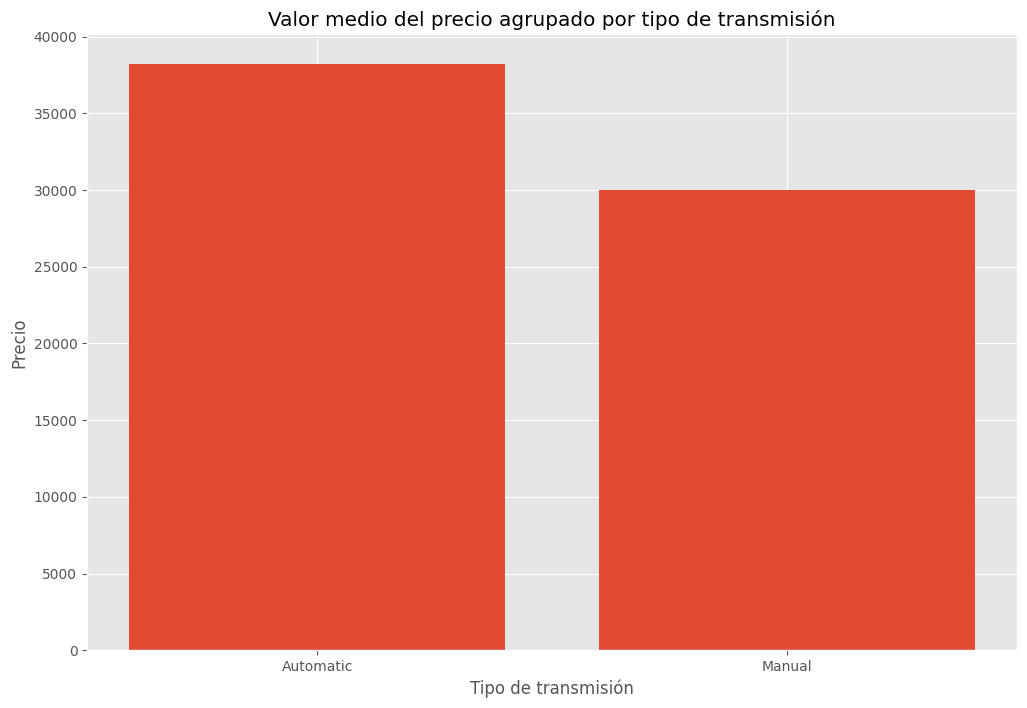

In [27]:
# Transmission: sin cambios.
Transmission_grouped = car[['Transmission', 'Price']].groupby('Transmission').mean().reset_index()
# Gráfico de columnas del valor medio del precio por cada categoría.
plt.bar(Transmission_grouped ['Transmission'], Transmission_grouped['Price'])
plt.title('Valor medio del precio agrupado por tipo de transmisión')
plt.xlabel('Tipo de transmisión')
plt.ylabel('Precio')

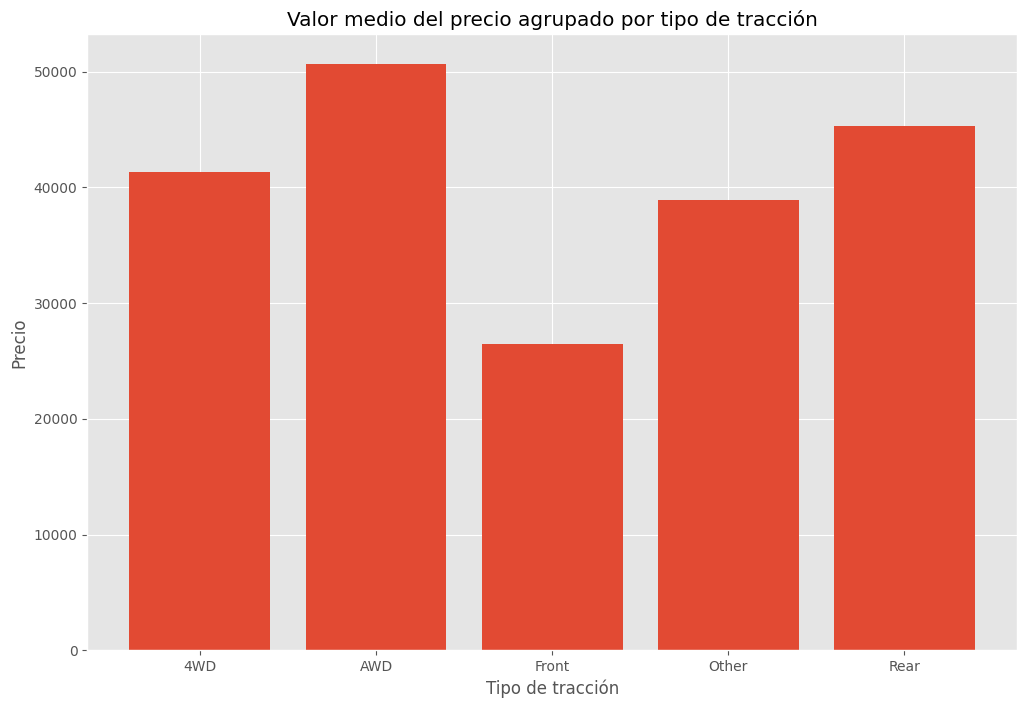

In [28]:
# DriveType
DriveType_grouped = car[['DriveType', 'Price']].groupby('DriveType').mean().reset_index()
# Gráfico de columnas del valor medio del precio por cada categoría.
plt.bar(DriveType_grouped ['DriveType'], DriveType_grouped['Price'])
plt.title('Valor medio del precio agrupado por tipo de tracción')
plt.xlabel('Tipo de tracción')
plt.ylabel('Precio')
# Se junta 4WD con Other.
l = []
for i in car['DriveType']:
  if i == '4WD':
    l.append('Other')
  else :
    l.append(i)
car['DriveType'] = l

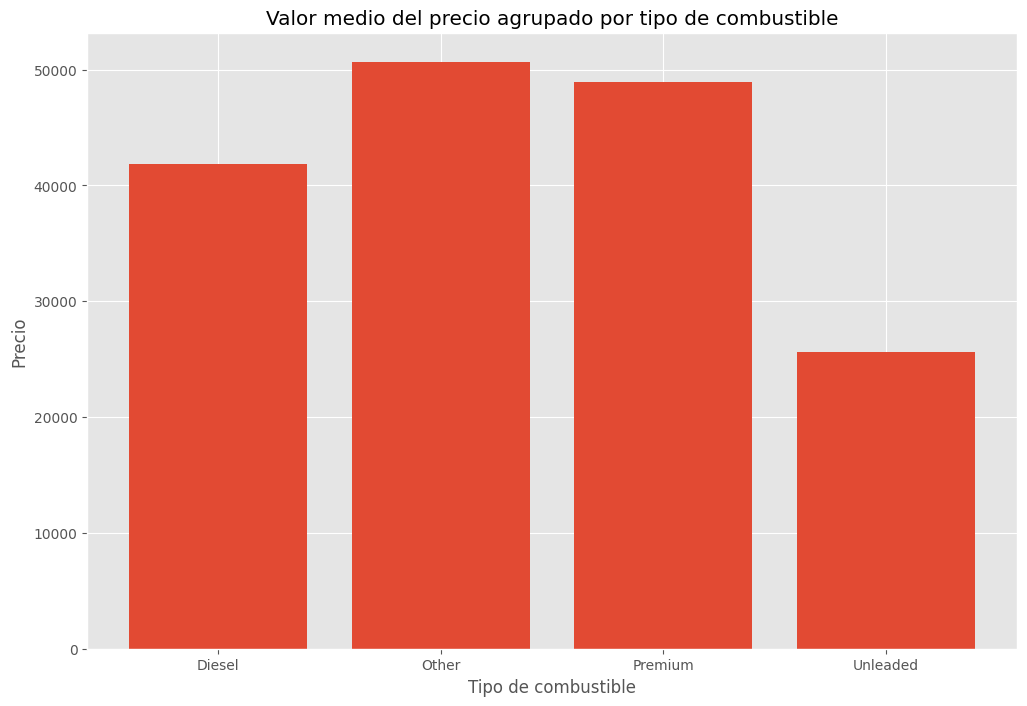

In [29]:
# FuelType
FuelType_grouped = car[['FuelType', 'Price']].groupby('FuelType').mean().reset_index()
# Gráfico de columnas del valor medio del precio por cada categoría.
plt.bar(FuelType_grouped ['FuelType'], FuelType_grouped['Price'])
plt.title('Valor medio del precio agrupado por tipo de combustible')
plt.xlabel('Tipo de combustible')
plt.ylabel('Precio')
# Se junta Premium con Other.
l = []
for i in car['FuelType']:
  if i == 'Premium':
    l.append('Other')
  else :
    l.append(i)
car['FuelType'] = l

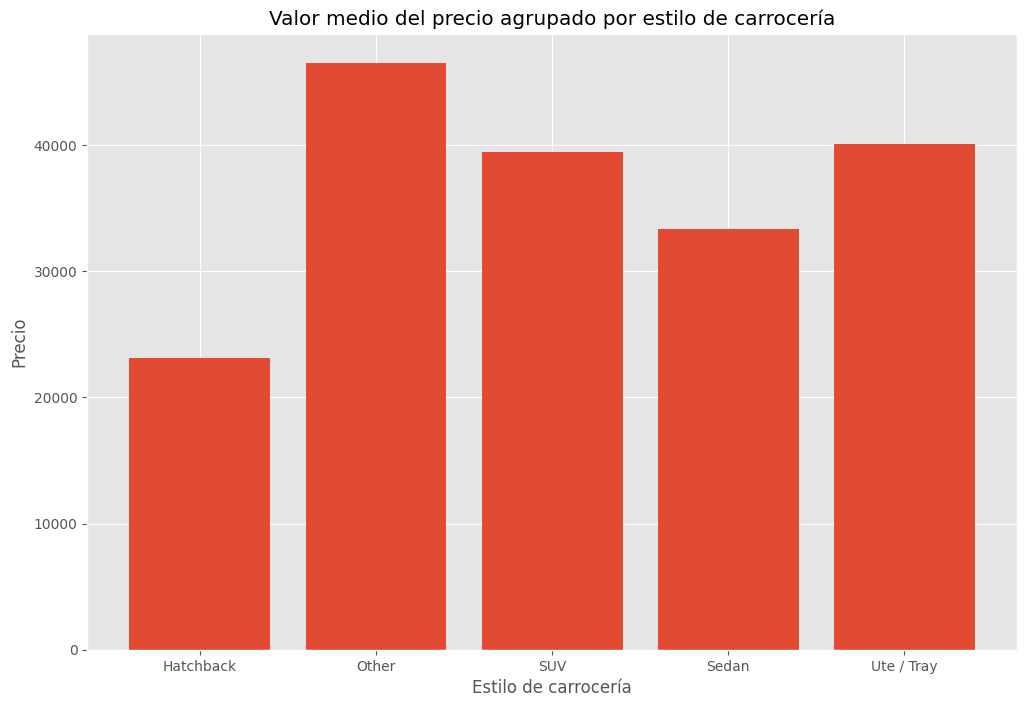

In [30]:
# BodyType
BodyType_grouped = car[['BodyType', 'Price']].groupby('BodyType').mean().reset_index()
# Gráfico de columnas del valor medio del precio por cada categoría.
plt.bar(BodyType_grouped ['BodyType'], BodyType_grouped['Price'])
plt.title('Valor medio del precio agrupado por estilo de carrocería')
plt.xlabel('Estilo de carrocería')
plt.ylabel('Precio')
# Se junta Ute/Tray con SUV.
l = []
for i in car['BodyType']:
  if i == 'SUV' or i == 'Ute / Tray':
    l.append('SUV/Ute/Tray')
  else :
    l.append(i)
car['BodyType'] = l

# Tratamiento de valores extremos

En primer lugar, se lleva a cabo un estudio de cada atributo de forma individual, distinguiendo entre las numéricas y las categóricas y con el objetivo de intentar prescindir de aquellos valores muy anómalos o fuera de rango, ya que distorsoniarían y afectarían negativamente a los resultados del futuro modelo en caso de incorporarse, puesto que el objetivo consiste en predecir el precio de un coche en Australia en condiciones más regulares o comunes.

Para las variables numéricas, se hace uso de un histograma para detectar la presencia de valores atípicos en cada variable. En caso positivo, mediante un Boxplot o diagrama de cajas, se confirma su presencia y, posteriormente, se decide cuáles de ellos deben ser eliminados, ya que no suele ser aconsejable mantener los valores extremos, puesto que puede ser perjudicial en el futuro modelo.

Year:


<Axes: >

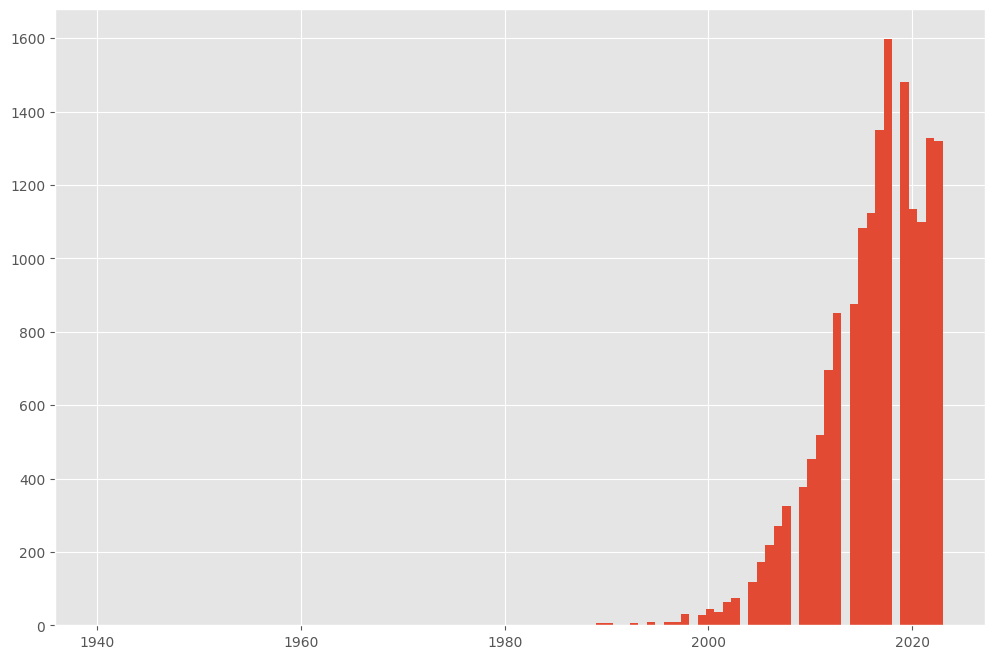

In [31]:
# Year
print('Year:')
car['Year'].hist(bins=100)
# Si hay valores fuera de rango.

<Axes: >

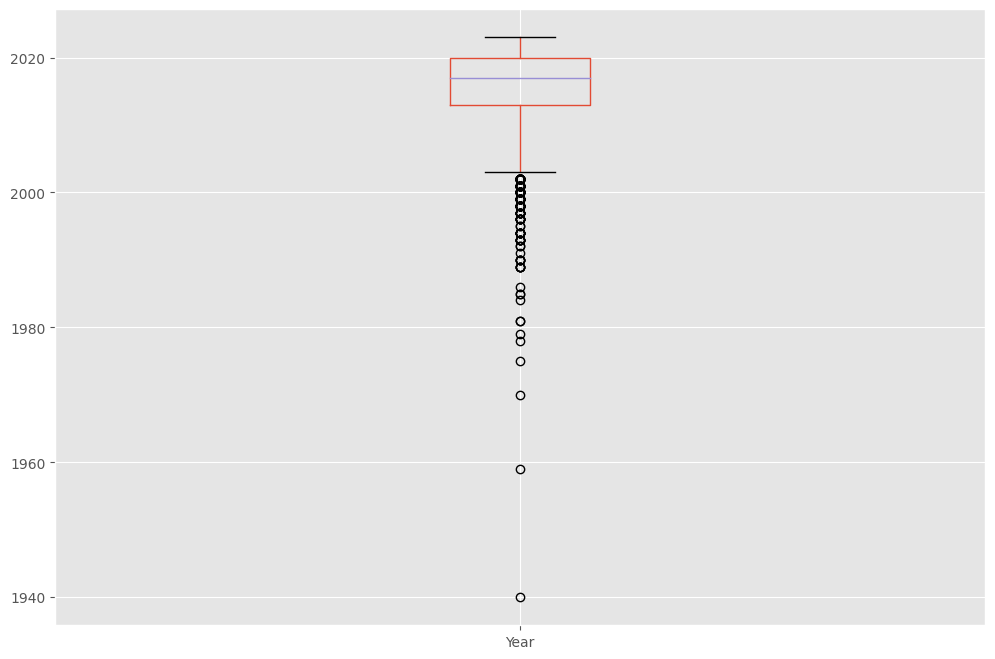

In [32]:
# box plot.
car.boxplot(column=['Year'])

In [33]:
# Se eliminan los registros con año de fabricación previo al 2000
print('Registros con Year < 2000:', car[car['Year'] < 2000].shape[0])
car.drop(car[car['Year'] < 2000].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros con Year < 2000: 119


Engine


<Axes: >

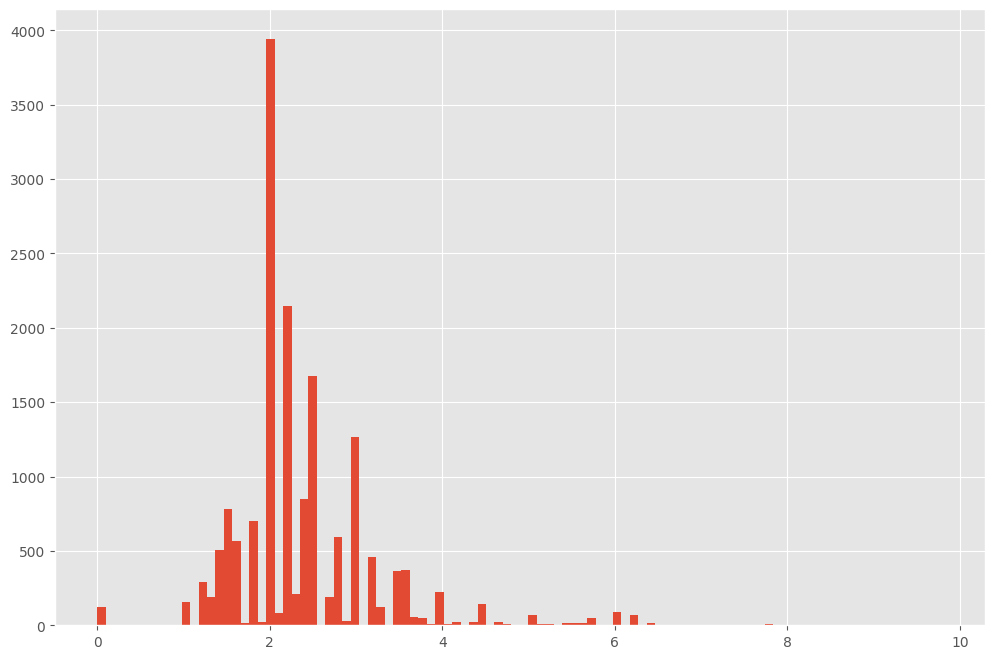

In [34]:
# Engine
print('Engine')
car['Engine'].hist(bins=100)
# Si hay valores fuera de rango.

<Axes: >

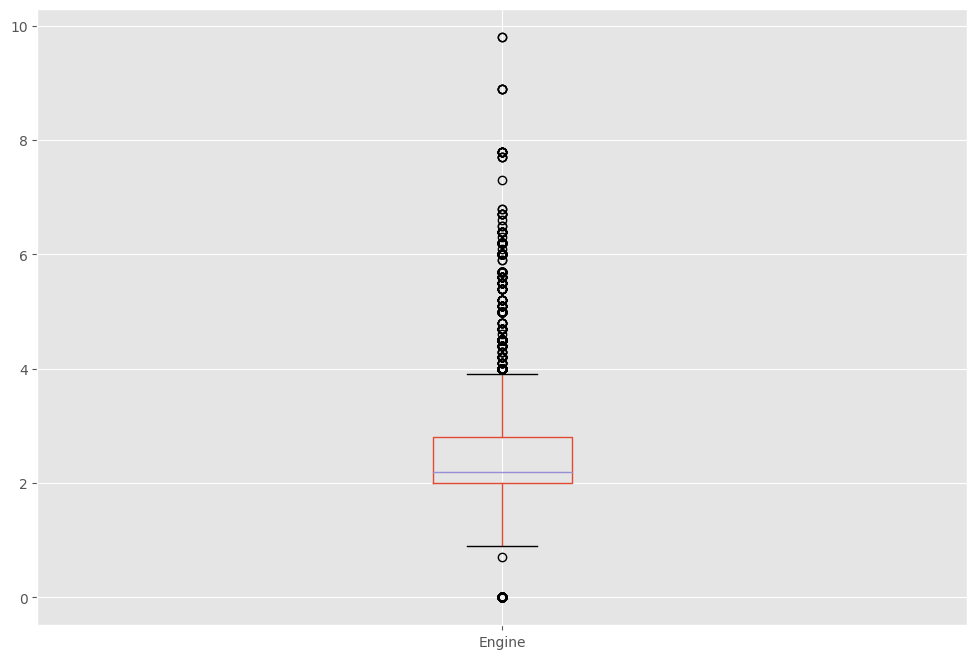

In [35]:
# box plot.
car.boxplot(column=['Engine'])

In [36]:
# Se prescinde de los 116 registros con valor mayor que 6 y de los 124 registros con valor menor que 1
print('Registros con Engine > 6:', car[car['Engine'] > 6].shape[0])
print('Registros con Engine < 1:', car[car['Engine'] < 1].shape[0])
car.drop(car[car['Engine'] > 6].index, inplace = True)
car.drop(car[car['Engine'] < 1].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros con Engine > 6: 116
Registros con Engine < 1: 124


FuelConsumption


<Axes: >

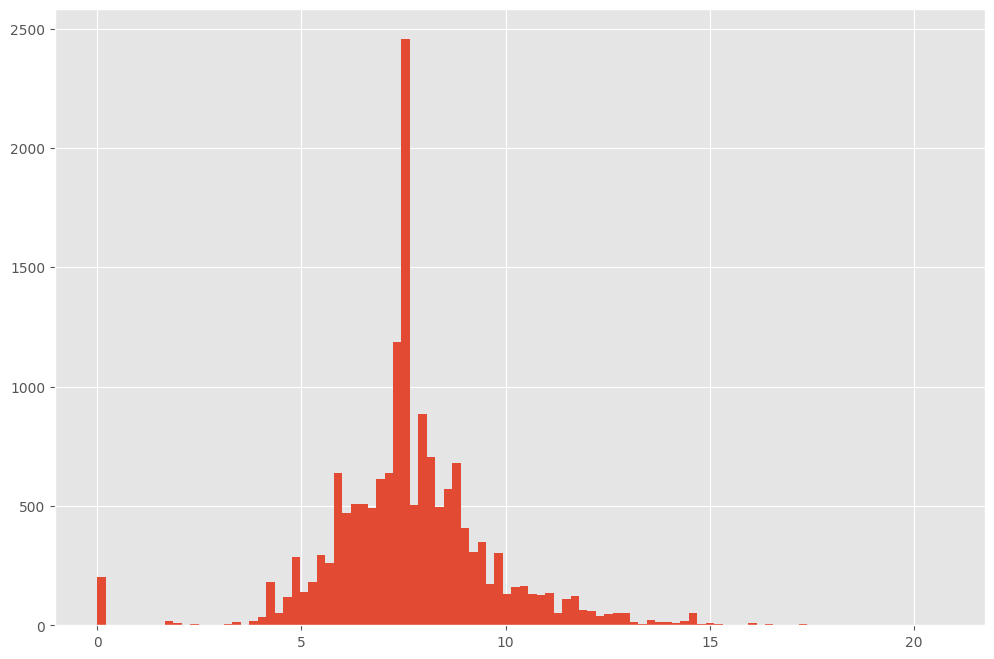

In [37]:
# FuelConsumption
# Year
print('FuelConsumption')
car['FuelConsumption'].hist(bins=100)
# Si hay valores fuera de rango.

Text(0.5, 1.0, 'Histograma de consumo de combustible después')

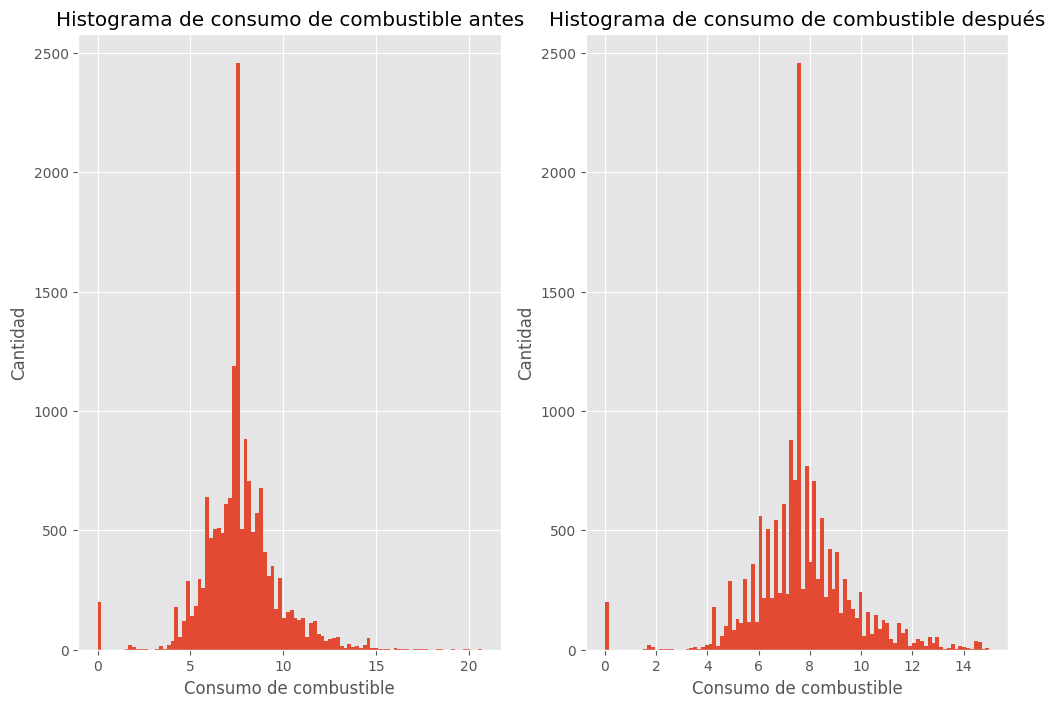

In [38]:
# Gráfico del consumo de combustible para la memoria del TFM, comparando el "antes" y el "después".
l = []
for i in car['FuelConsumption']:
  if i <= 15:
    l.append(i)

s = pd.Series(l)

plt.subplot(1, 2, 1)

car['FuelConsumption'].hist(bins=100)
plt.xlabel('Consumo de combustible')
plt.ylabel('Cantidad')
plt.title('Histograma de consumo de combustible antes')

plt.subplot(1, 2, 2)
s.hist(bins=100)
plt.xlabel('Consumo de combustible')
plt.ylabel('Cantidad')
plt.title('Histograma de consumo de combustible después')

<Axes: >

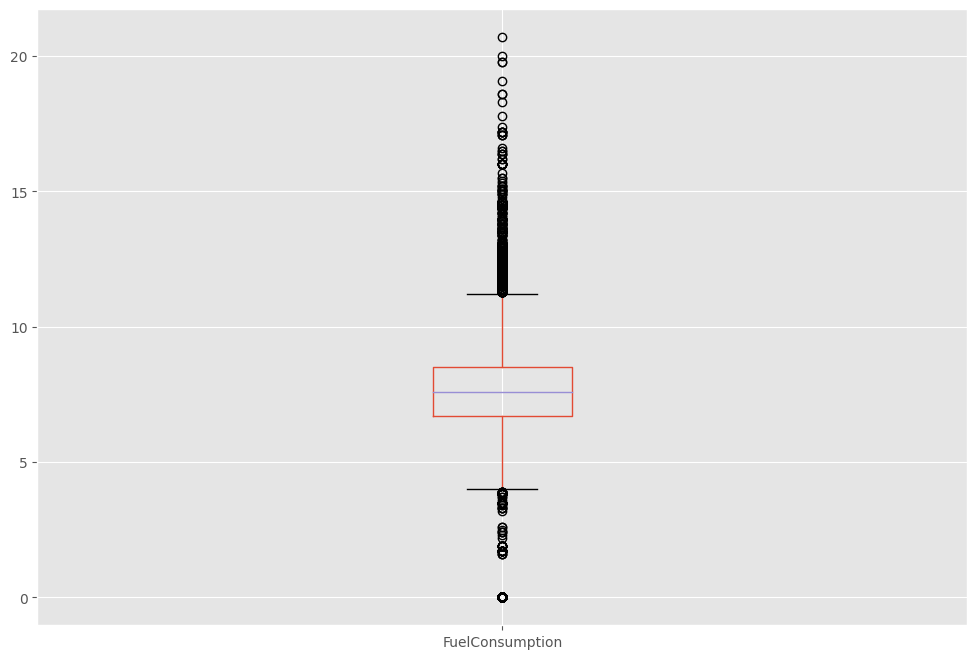

In [39]:
# box plot.
car.boxplot(column=['FuelConsumption'])

In [40]:
# Se eliminan los 47 registros con consumo de combustible superior a 15.
print('Registros con Fuel Consumption > 15:', car[car['FuelConsumption'] > 15].shape[0])
car.drop(car[car['FuelConsumption'] > 15].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros con Fuel Consumption > 15: 47


Kilometres


<Axes: >

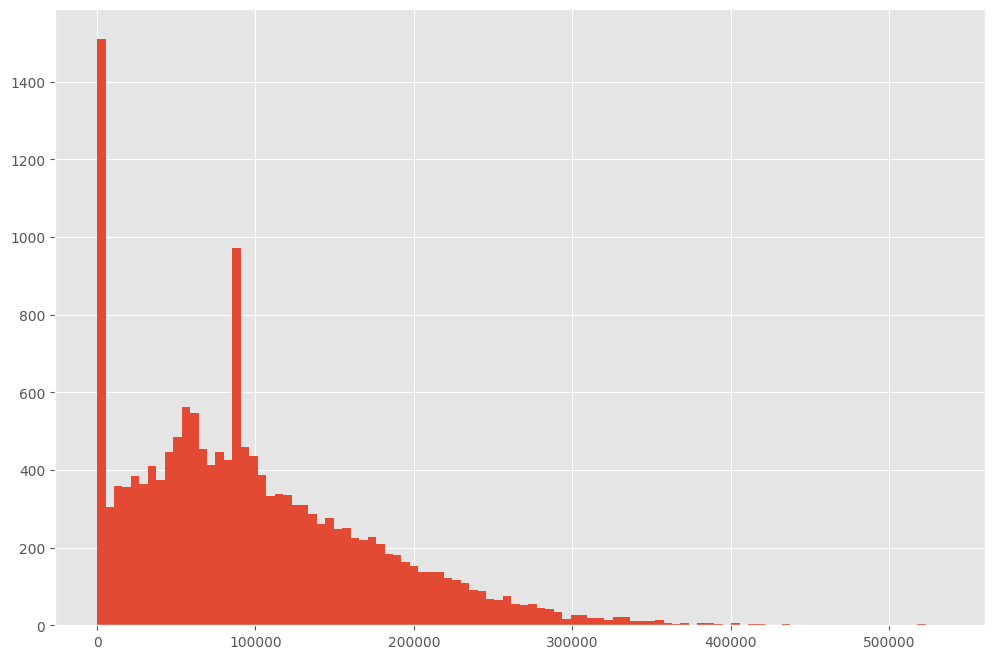

In [41]:
# Kilometres
print('Kilometres')
car['Kilometres'].hist(bins=100)
# Si hay valores fuera de rango.

<Axes: >

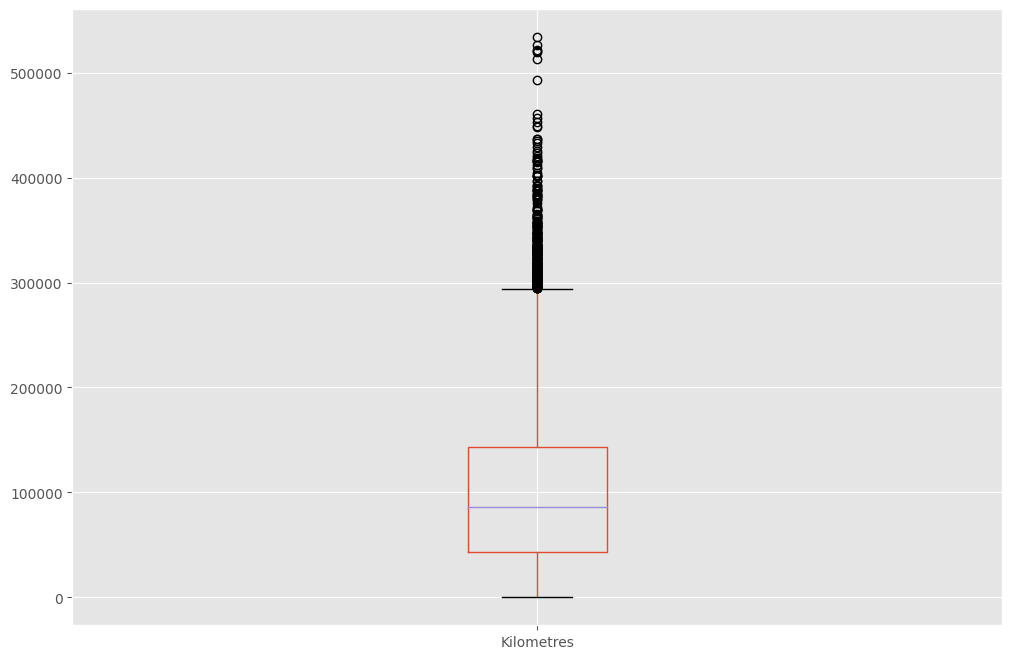

In [42]:
# box plot.
car.boxplot(column=['Kilometres'])

In [43]:
# Se eliminan los 87 registros con un número de kilómetros recorridos mayor a 350000.
print('Registros Kilometres > 350000:', car[car['Kilometres'] > 350000].shape[0])
car.drop(car[car['Kilometres'] > 350000].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros Kilometres > 350000: 87


Price


<Axes: >

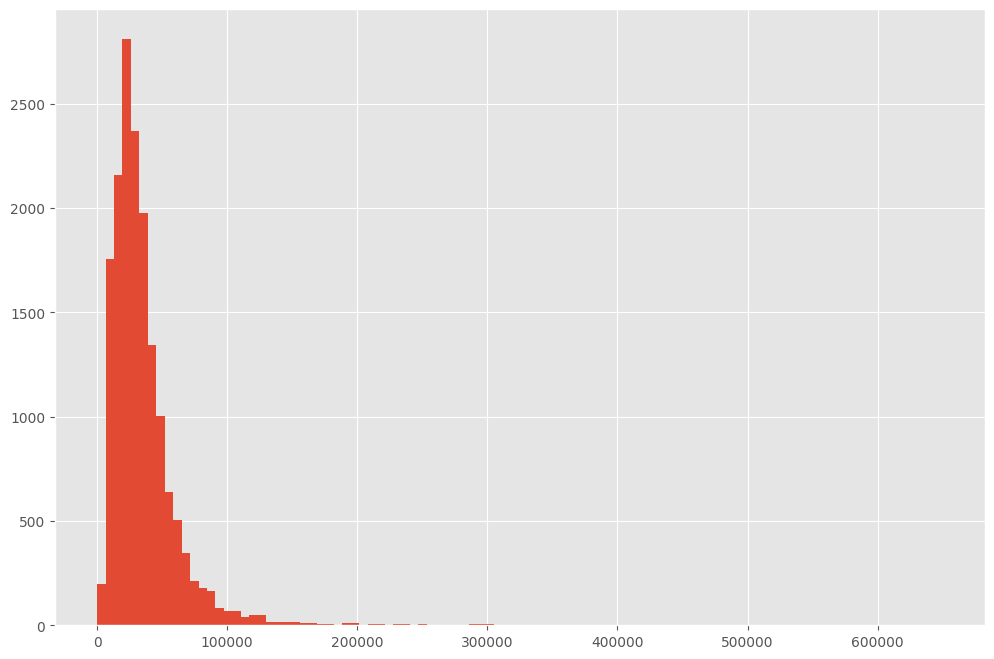

In [44]:
# Price
print('Price')
car['Price'].hist(bins=100)
# Si hay valores fuera de rango.

<Axes: >

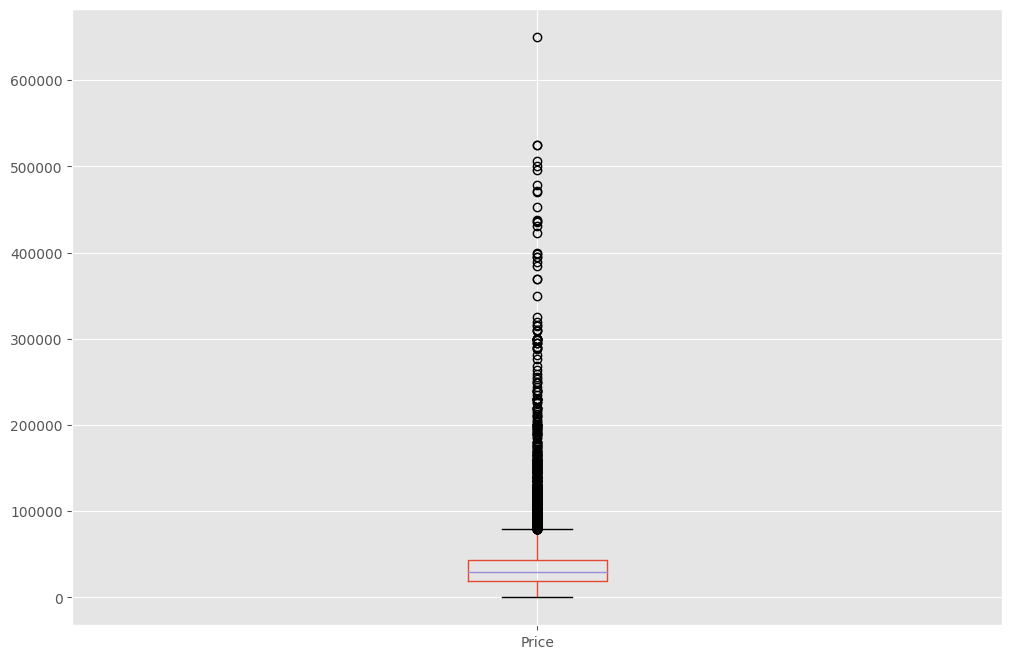

In [45]:
# box plot.
car.boxplot(column=['Price'])

Text(0.5, 1.0, 'Diagrama de cajas del precio después')

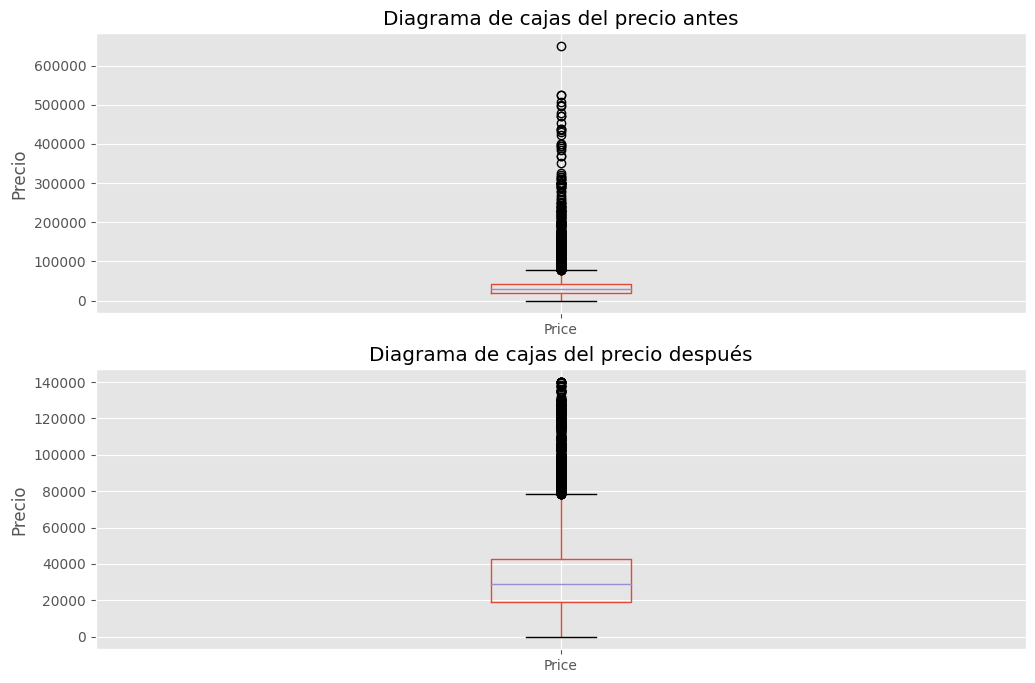

In [46]:
# Gráfico del precio para la memoria del TFM, comparando el "antes" y el "después".
l = []
p = pd.DataFrame()
for i in car['Price']:
  if i <= 140000:
    l.append(i)

s = pd.Series(l)
p['Price'] = s

plt.subplot(2, 1, 1)

car.boxplot(column=['Price'])
plt.ylabel('Precio')
plt.title('Diagrama de cajas del precio antes')

plt.subplot(2, 1, 2)
p.boxplot(column=['Price'])
plt.ylabel('Precio')
plt.title('Diagrama de cajas del precio después')

In [47]:
# Se prescinde de los 185 registros con precio mayor a 140000.
print('Registros:', car[car['Price'] > 140000].shape[0])
car.drop(car[car['Price'] > 140000].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros: 185


Cylinders


<Axes: >

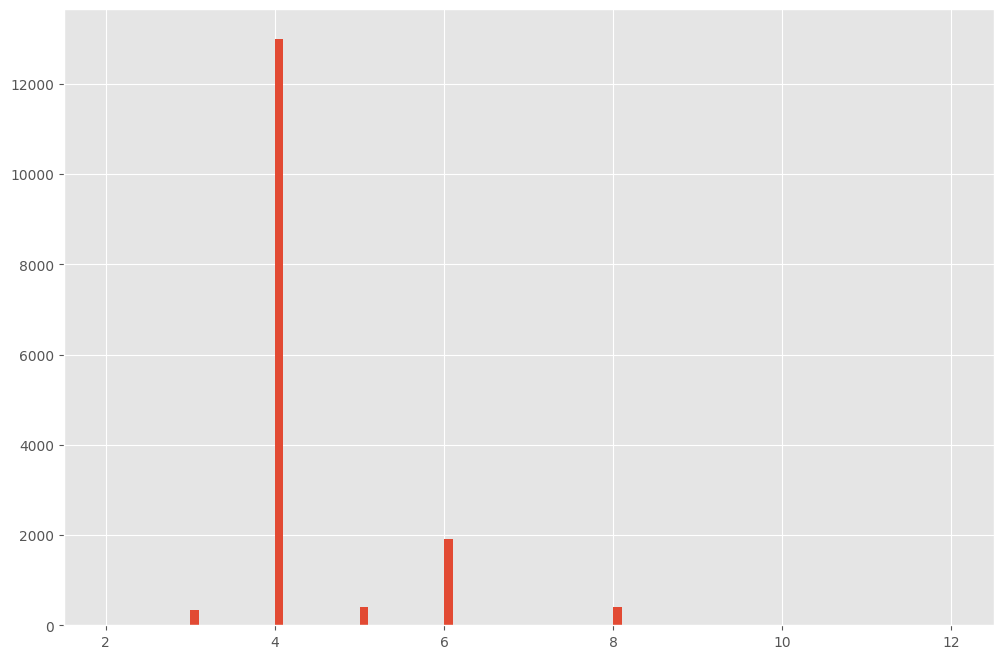

In [48]:
# Cylinders
print('Cylinders')
car['Cylinders'].hist(bins=100)

<Axes: >

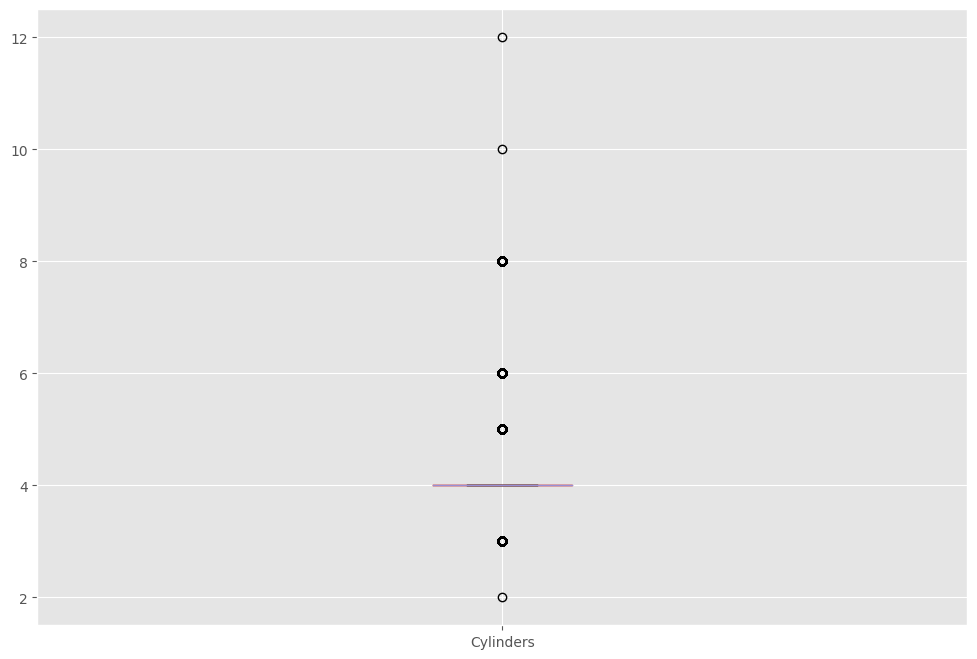

In [49]:
# box plot.
car.boxplot(column=['Cylinders'])

In [50]:
#  Se prescinden de los 3 registros con un número mayor que 8 o con un número menor que 3.
print('Registros:', car[car['Cylinders'] > 8].shape[0])
print('Registros:', car[car['Cylinders'] < 3].shape[0])
car.drop(car[car['Cylinders'] > 8].index, inplace = True)
car.drop(car[car['Cylinders'] < 3].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros: 2
Registros: 1


Doors


<Axes: >

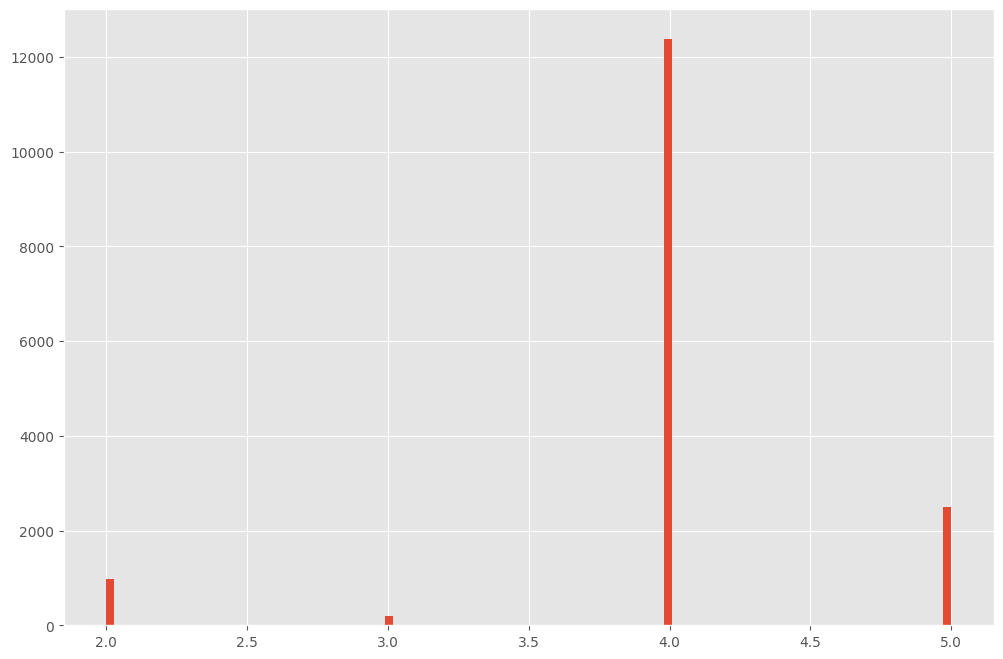

In [51]:
# Doors
print('Doors')
car['Doors'].hist(bins=100)
# No hay valores fuera de rango.

Seats


<Axes: >

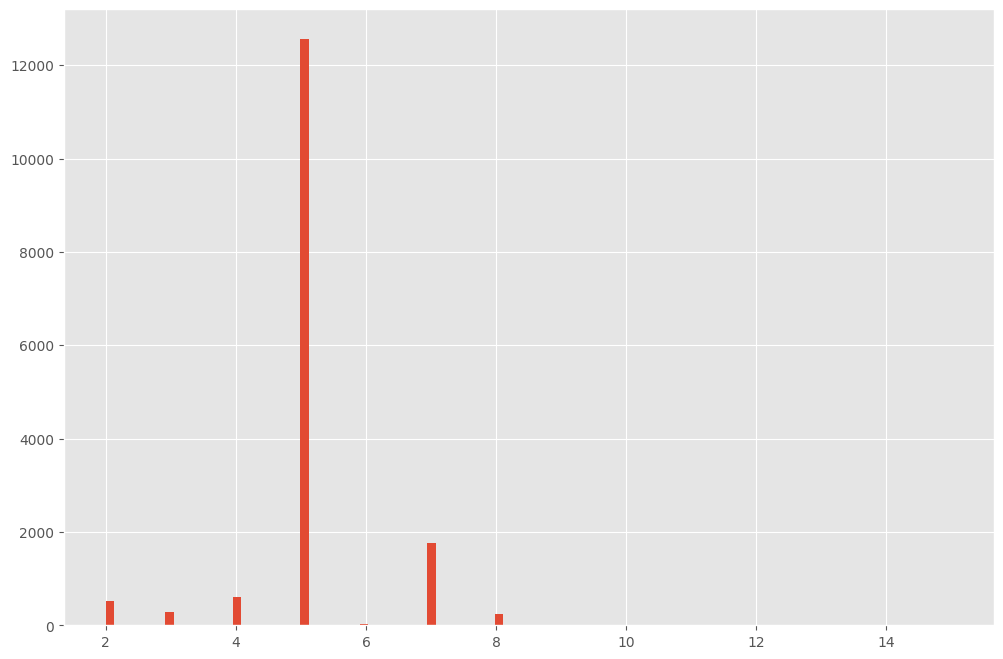

In [52]:
# Seats
print('Seats')
car['Seats'].hist(bins=100)
# Si hay valores fuera de rango.

<Axes: >

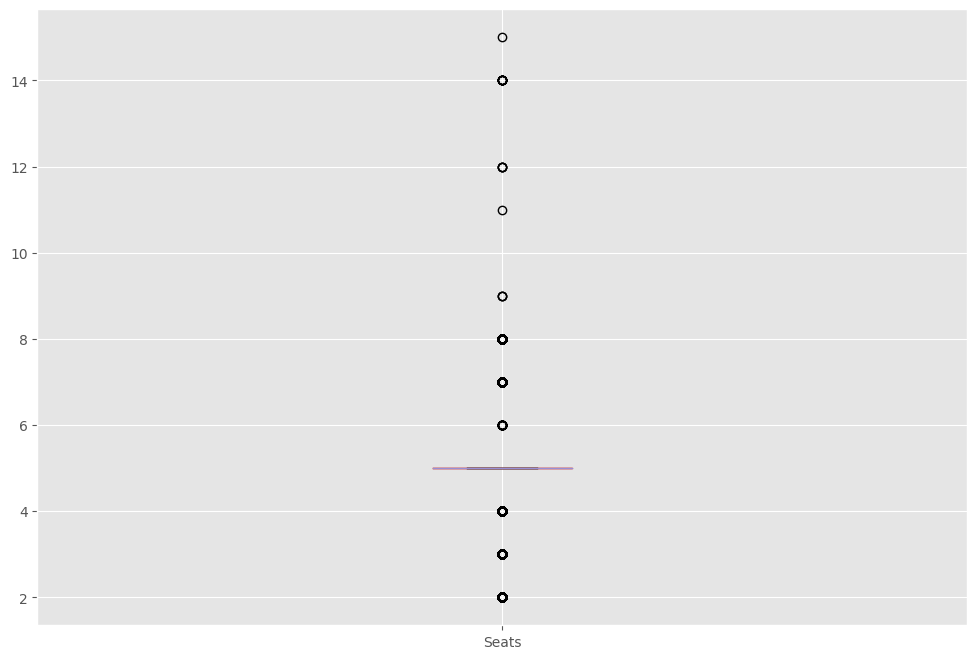

In [53]:
# box plot.
car.boxplot(column=['Seats'])

In [54]:
#  Se eliminan los 20 registros con un número de asientos mayor que 8.
print('Registros:', car[car['Seats'] > 8].shape[0])
car.drop(car[car['Seats'] > 8].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros: 20


Por otro lado, para las variables categóricas, se elabora un gráfico de columnas para comprobar si alguna de las categorías es prescindible o si se puede agrupar con otra.

Text(0.5, 1.0, 'Diagrama de columnas del estado del vehículo')

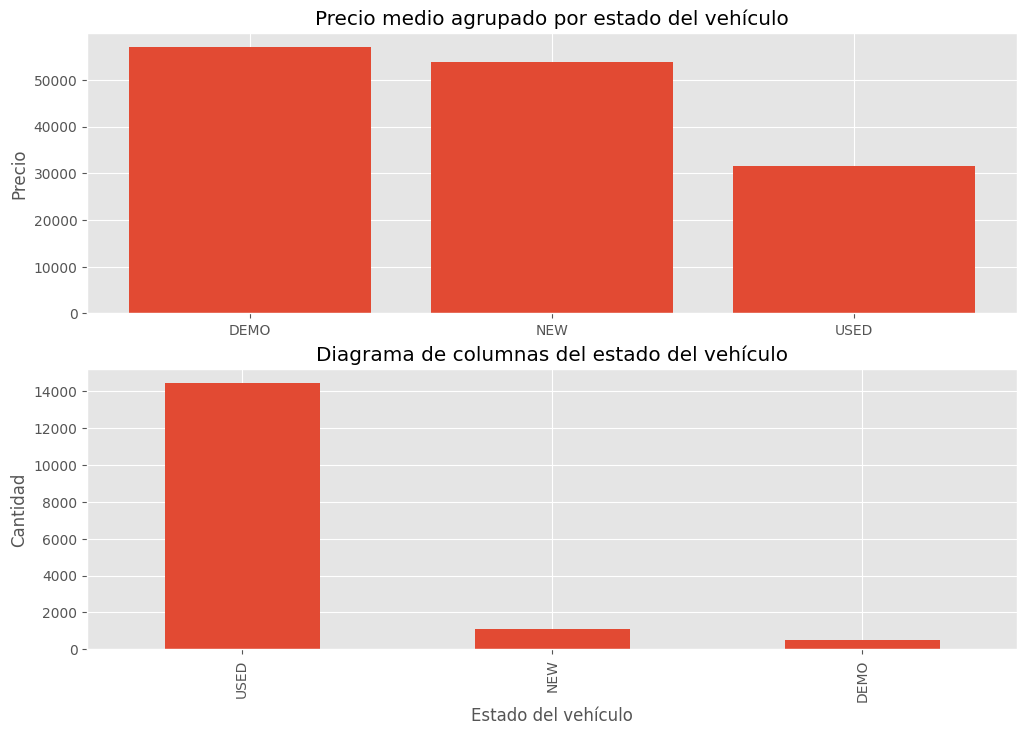

In [55]:
# UsedOrNew
plt.subplot(2, 1, 1)
UsedOrNew_grouped = car[['UsedOrNew', 'Price']].groupby('UsedOrNew').mean().reset_index()
plt.bar(UsedOrNew_grouped ['UsedOrNew'], UsedOrNew_grouped['Price'])
plt.ylabel('Precio')
plt.title('Precio medio agrupado por estado del vehículo')



plt.subplot(2, 1, 2)
car['UsedOrNew'].value_counts().plot.bar()
plt.ylabel('Cantidad')
plt.xlabel('Estado del vehículo')
plt.title('Diagrama de columnas del estado del vehículo')

In [56]:
# Se junta DEMO con NEW, puesto que tienen precio medio similar y solo hay 500 coches en estado DEMO.
l = []
for i in car['UsedOrNew']:
  if i == 'DEMO' or i == 'NEW':
    l.append('NOT USED')
  else :
    l.append(i)
car['UsedOrNew'] = l

En referencia a las variables categóricas que definen el tipo de transmisión, tipo de conducción, tipo de combustible y estilo, se decide no realizar ninguna modificación, puesto que todas las categorías presentan un número considerable de vehículos, siendo su precio medio bastante diferente.

Automatic    14212
Manual        1821
Name: Transmission, dtype: int64


<Axes: >

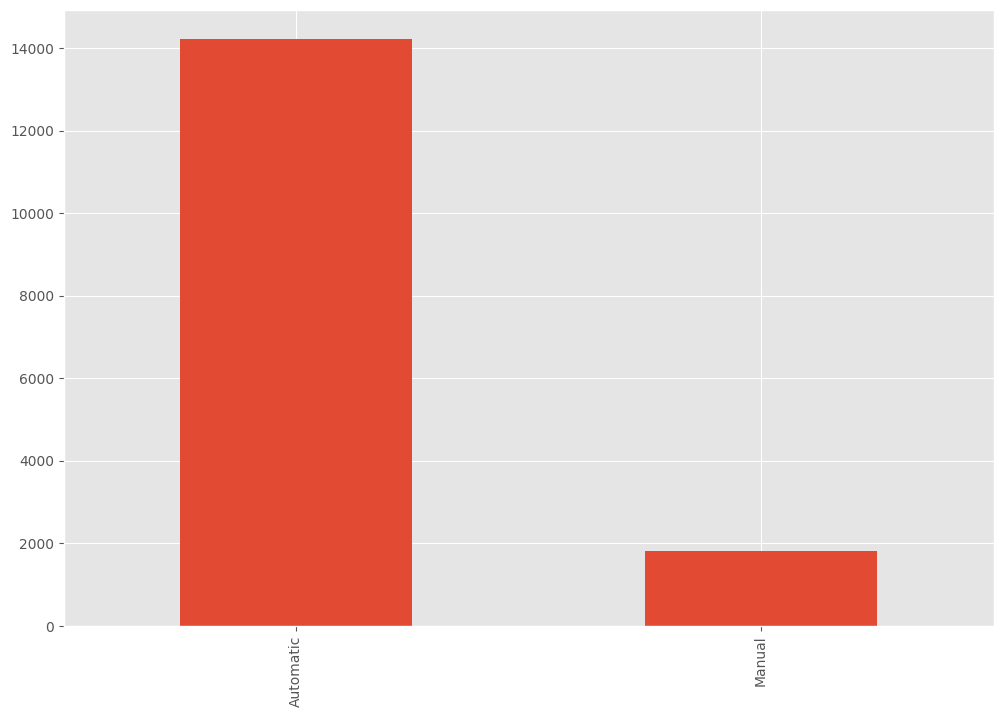

In [57]:
# Transmission
print(car['Transmission'].value_counts())
car['Transmission'].value_counts().plot.bar()

Front    6883
Other    4110
AWD      2972
Rear     2068
Name: DriveType, dtype: int64


<Axes: >

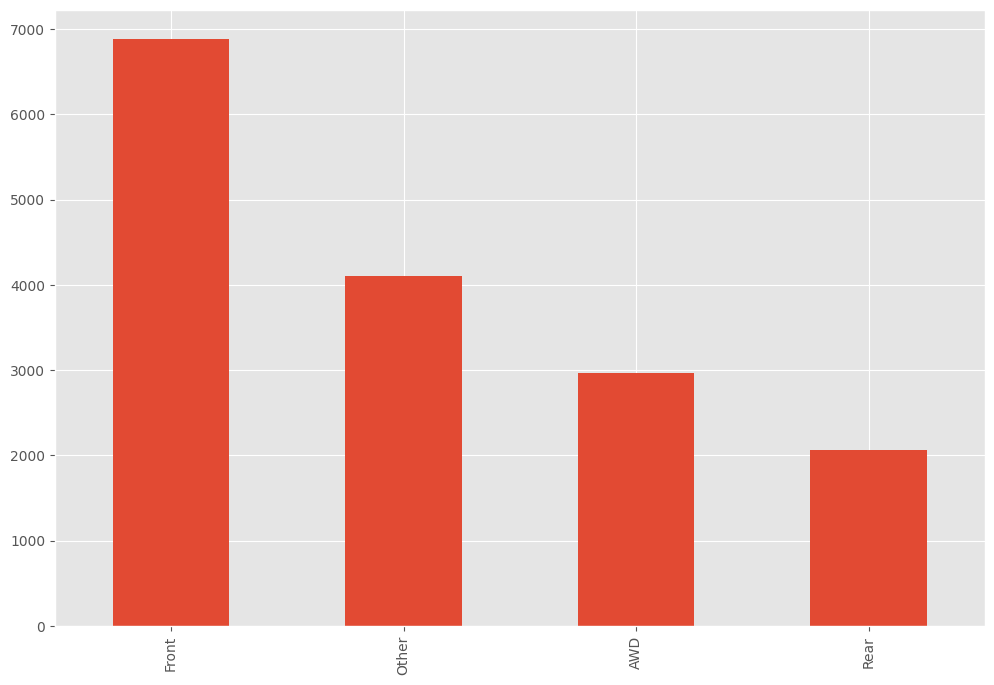

In [58]:
# DriveType
print(car['DriveType'].value_counts())
car['DriveType'].value_counts().plot.bar()

Unleaded    6855
Diesel      4743
Other       4435
Name: FuelType, dtype: int64


<Axes: >

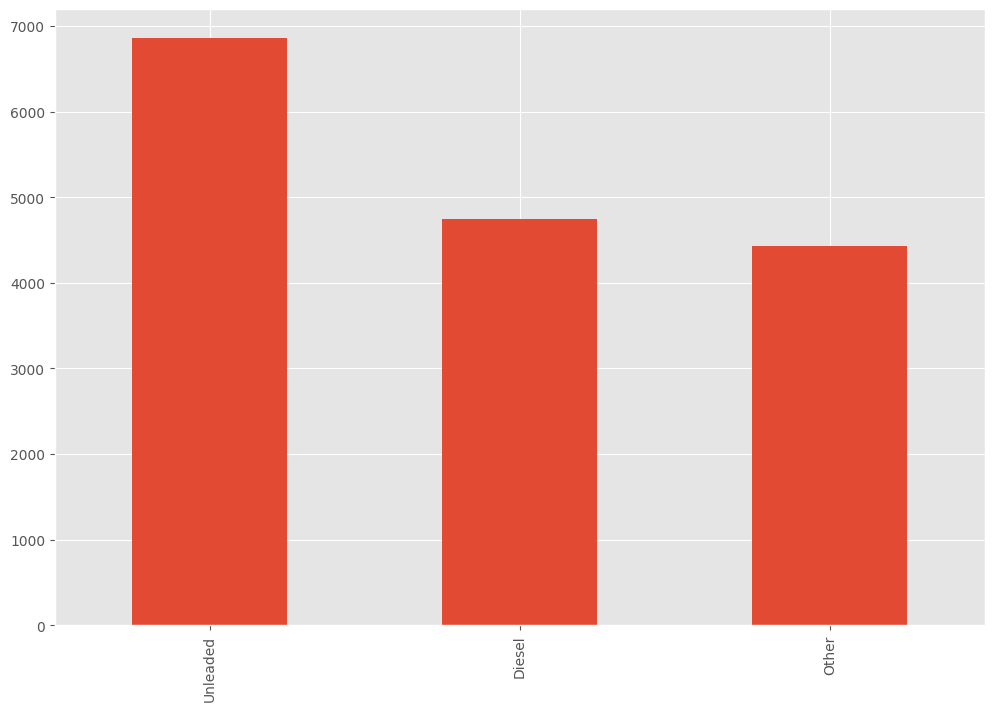

In [59]:
# FuelType
print(car['FuelType'].value_counts())
car['FuelType'].value_counts().plot.bar()

SUV/Ute/Tray    9119
Hatchback       2655
Other           2416
Sedan           1843
Name: BodyType, dtype: int64


<Axes: >

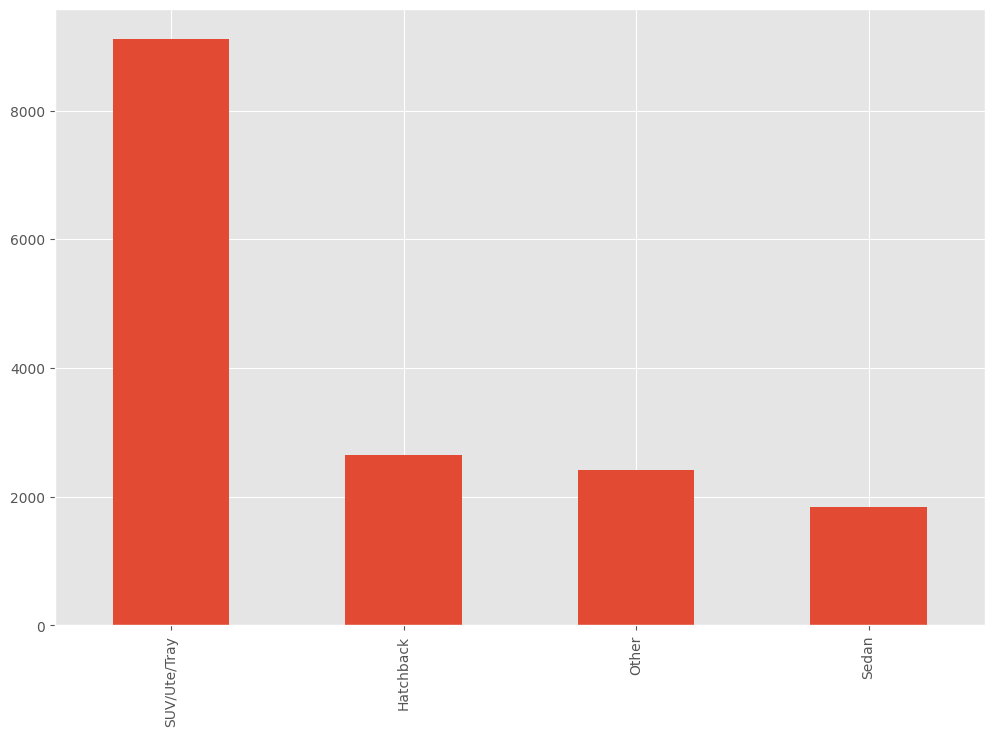

In [60]:
# BodyType
print(car['BodyType'].value_counts())
car['BodyType'].value_counts().plot.bar()

Ahora bien, aunque sí se haya trabajado con los valores fuera de rango de cada variable individualmente, no se ha realizado ningún tratamiento acerca de aquellos registros con valores extremos teniendo en cuenta todas las características simultáneamente. Es por esta razón por la que, a continuación, considerando las 10 variables numéricas del conjunto de datos, se utiliza el algoritmo DBSCAN para la formación y agrupación de clústeres y la consecuente detección de valores extremos.

El método DBSCAN es un algoritmo no supervisado aplicado sobre conjuntos de datos con variables numéricas que tiene por objetivo descubrir grupos a partir de formas arbitrarias de cualquier conjunto de datos. Básicamente, la idea es que  los diferentes clústeres o grupos contienen aquellos registros del conjunto de datos cuyas proyecciones formen una región densa de puntos, de forma que los distintos clústeres están separados por regiones poco densas. Es decir, aquellos registros cuyas proyecciones disten mucho de las demás forman un clúster por sí solas, siendo, por tanto, un valor fuera de rango.

Para la aplicación de dicho algoritmo sobre el conjunto de datos tratado, después de seleccionar solamente las 10 variables numéricas y normalizar toda la información, es necesario fijar un número mínimo de puntos requeridos para que una región se considere densa y un épsilon, que corresponde al radio específico de la esfera en el que contar el número de puntos situados a una distancia cerca.

El mínimo de puntos seleccionado es 2, de forma que si dos coches se encuentran en una región cerca  es suficiente para considerarla densa. A partir de esta elección, mediante el siguiente gráfico de índices de la matriz de distancias, se observa el valor de épsilon que conviene escoger.


In [61]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
num_cols = ['Year', 'Engine', 'FuelConsumption', 'Kilometres', 'Cylinders', 'Doors', 'Seats', 'DollarAustralian', 'PriceIndex', 'Price']
features_norm = min_max_scaler.fit_transform(car[num_cols])

## DBSCAN
from scipy import cluster
import sklearn.metrics

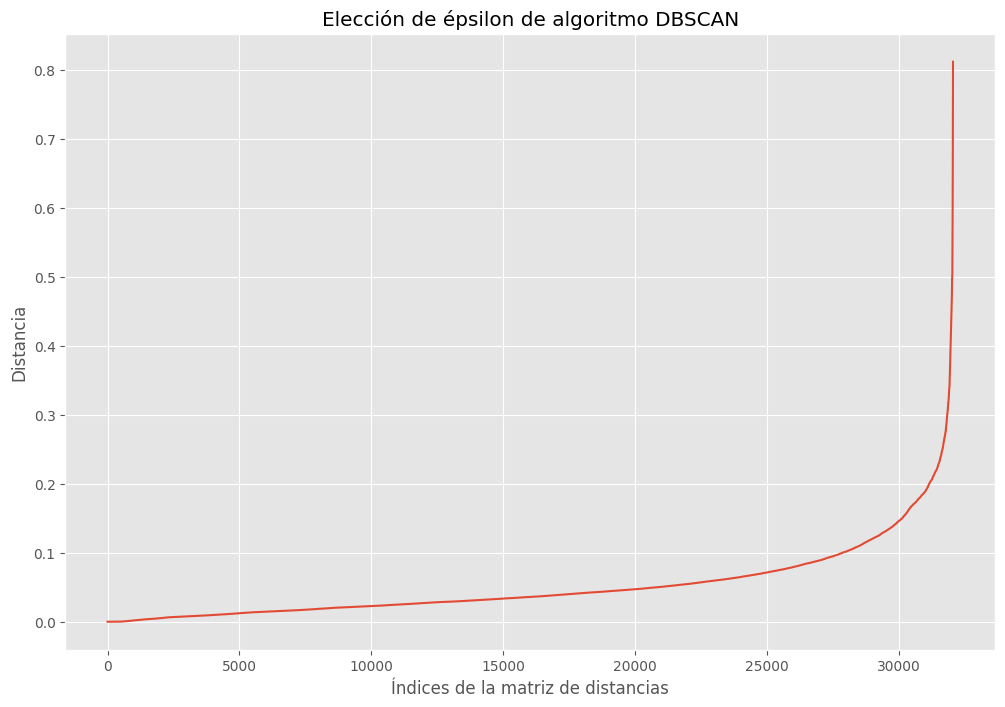

In [62]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
num_cols = ['Year', 'Engine', 'FuelConsumption', 'Kilometres', 'Cylinders', 'Doors', 'Seats', 'DollarAustralian', 'PriceIndex', 'Price']
features_norm = min_max_scaler.fit_transform(car[num_cols])

## DBSCAN
from scipy import cluster
import sklearn.metrics
dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
matdist= dist.pairwise(features_norm)
minPts=2
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(features_norm, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(features_norm):
    for j in range(len(features_norm)):
        if Ar[i][j] != 0:
            seq.append(matdist[i][j])

seq.sort()
# establecer intervalo ejes
fig = plt.figure()
ax = fig.gca()
#ax.set_xticks(np.arange(0, 120, 10))
#ax.set_yticks(np.arange(0, 7, 0.5))

plt.plot(seq)
plt.xlabel('Índices de la matriz de distancias')
plt.ylabel('Distancia')
plt.title('Elección de épsilon de algoritmo DBSCAN')

plt.show()

Parece que, tomando la distancia como referencia, la función tiene un patrón convexo entre los valores 0.01 y 0.4 (momento de cambio de tendencia). Por tanto, probando diferentes valores de épsilon entre 0.01 y 0.4, la idea consiste en aplicar el método DBSCAN y contemplar el número de clústeres y de outliers que se van formando.

In [63]:
from sklearn.cluster import DBSCAN
print("Para los distintos epsilons, se muestra el número de clústers y outliers obtenidos con el método DBSCAN:\n")
for eps in np.arange(0.05, 0.45, 0.05):
  db = DBSCAN(eps, min_samples=minPts).fit(features_norm)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))


Para los distintos epsilons, se muestra el número de clústers y outliers obtenidos con el método DBSCAN:

  0.05, 1395, 4412
  0.10, 722, 1550
  0.15, 427, 674
  0.20, 235, 320
  0.25, 96, 135
  0.30, 62, 72
  0.35, 36, 41
  0.40, 28, 29


Debido a que, por una parte, se pretende conservar la mayor información posible y, por otra parte, se requiere prescindir de aquellos registros con valores que realmente estén fuera de rango, se decide que 0.3 se trata de un buen valor de épsilon a considerar, ya que, con valores inferiores, el número de valores extremos es bastante elevado (asumiendo demasiada pérdida de información relevante en caso de prescindir de ellos) y, con valores superiores a 0.3, el número de clústeres formados es demasiado bajo, arriesgándose a incorporar demasiados valores fuera de rango con su elección.

In [64]:
# Se presinde de los 72 registros más extremos, a fin de evitar distorsionar los resultados.
eps= 0.3
db = DBSCAN(eps, min_samples=minPts).fit(features_norm)
labels = db.labels_


In [65]:
j = 0
l = []
for i in labels:
  if i == -1:
    l.append(j)
  j = j+1

car.drop(l, axis=0, inplace=True)
car.reset_index(drop = True, inplace = True)

In [66]:
print('El dataset contiene', car.shape[0], 'filas y', car.shape[1], 'columnas.')
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

El dataset contiene 15961 filas y 15 columnas.
Las columnas, con sus correspondientes tipos, son las siguientes:
 Year                  Int64
UsedOrNew            object
Transmission         object
Engine              float64
DriveType            object
FuelType             object
FuelConsumption     float64
Kilometres          float64
Cylinders             Int64
BodyType             object
Doors                 Int64
Seats                 Int64
Price               float64
DollarAustralian    float64
PriceIndex          float64
dtype: object


# Datos innecesarios

## Datos desinformativos

Por un lado, ninguna de las columnas finales aglutina el 95% con un mismo valor, lo que confirma que no se dispone de ningún atributo incorrecto.

In [67]:
num_rows = len(car.index)
low_information_cols = []

for col in car.columns:
    cnts = car[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

## Datos duplicados

Por otro lado, después de todas las transformaciones realizadas, el conjunto de datos contiene 70 filas duplicadas. Este hecho se debe a que, como se ha agrupado, transformado y reducido alguna información, inevitablemente existen vehículos con las mismas características finales, aunque inicialmente correspondían a coches distintos. La decisión que se toma es la de eliminar dichos duplicados, ya que, de incorporarse en el futuro modelo lineal generalizado, se estaría dando más peso a estas filas, lo que no concuerda con la finalidad del problema, pues este consiste en dar el mismo peso a cada uno de los vehículos con las características finales obtenidas para tener una predicción lo más eficiente posible, sin estar sesgada.

In [68]:
car_dedupped = car.drop_duplicates()
print(car.shape)
print(car_dedupped .shape)

# Se eliminan las filas duplicadas.
car.drop_duplicates(inplace = True)

(15961, 15)
(15891, 15)


In [69]:
print('El dataset final contiene', car.shape[0], 'filas y', car.shape[1], 'columnas.')
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

El dataset final contiene 15891 filas y 15 columnas.
Las columnas, con sus correspondientes tipos, son las siguientes:
 Year                  Int64
UsedOrNew            object
Transmission         object
Engine              float64
DriveType            object
FuelType             object
FuelConsumption     float64
Kilometres          float64
Cylinders             Int64
BodyType             object
Doors                 Int64
Seats                 Int64
Price               float64
DollarAustralian    float64
PriceIndex          float64
dtype: object


# Comparativa entre los datos iniciales y finales

Inicialmente, se había empezado el problema con tres datasets distintos con gran variedad de información a considerar. Sin embargo, realizando el siguiente flujo de selección, limpieza y transformación de datos acorde al objetivo planteado, se ha simplificado significativamente la fuente de datos a tratar.




*   En primer lugar, se han unificado los tres conjuntos de datos en uno solo, definiendo un dataset de 16734 registros de vehículos, 20 variables de entrada distintas y el atributo de salida del precio.
*   Seguidamente, se han realizado todas las transformaciones referentes al tipo de cada característica, reduciendo categorías en algunas variables no numéricas y descartando seis de ellas por su difícil manejabilidad en el futuro modelo, quedando el número de variables de entrada reducido a 14.
*   A continuación, se ha llevado a cabo la correspondiente imputación de todos los valores perdidos, tanto para los atributos numéricos como para las variables categóricas, y realizando un método particular en cada caso.
*   Posteriormente, se ha gestionado un ejercicio de selección de características, comprobando la relación entre las variables de entrada y la variable objetivo, decidiéndose conservar todas ellas con el matiz de que se han reducido algunas categorías de tres variables no numéricas.

*   El tratamiento de los valores extremos se ha dividido en dos secciones: por una parte, se ha elaborado un estudio particular para cada una de las características del modelo, prescindiendo de aquellos valores fuera de rango del objetivo planteado; mientras que, por otra parte, se ha utilizado el método DBSCAN para detectar y eliminar aquellos registros fuera de rango considerando las 10 variables numéricas de forma simultánea. En este punto, el número de registros del conjunto de datos ha quedado reducido a 15961.

*   Finalmente, se han identificado los datos innecesarios e inconsistentes, argumentando la eliminación de los duplicados y quedando el dataset simplificado a 15891 registros, 14 columnas independientes o de entrada y el precio como variable dependiente o de salida.

# Anexo y exportación de resultados

Finalmente, se confirma que la variable del precio toma valores enteros y se exporta el fichero final listo para la siguiente fase de modelado.

In [70]:
aux = True
for i in car['Price']: # Se recorre el campo.
  if not(i.is_integer()): # Se pregunta si es real.
    aux = False # Si hay algún número real en este campo aux será falso.
    break

# En caso de que solo haya valores enteros en ambos campos (sin contar los Missings Values), aux será True.
print('¿Los valores de Price son enteros?', aux)

¿Los valores de Price son enteros? True


In [71]:
car.to_csv('Australian vehicle Prices Clean.csv', index = False)